# Student Project - Machine Learning for Renewable Energy Systems
## Coding Track: Forecasting Building Electrictiy Data

### Task: Predict the electricity demand of the next hour, day and week of at least one building per category.



This notebook was created as project in the course of the seminar [Machine Learning for Renewable Energy Systems](https://www.mlsustainableenergy.com/teaching/machine-learning-for-renewable-energy-systems/) in the reserach group [
Machine Learning in Sustainable Energy Systems](https://www.mlsustainableenergy.com/) at the University of Tübingen. <br> 
The code and the forecasting has been carried out in this jupyter notebook and is the work of 

    Markus Deppner   4106780   markus.deppner@student.uni-tuebingen.de
    
This project works with data from ["The Building Data Genome 2 (BDG2) Data-Set"](https://github.com/buds-lab/building-data-genome-project-2) and aims to forecast the electricity demand of at least one building per category. To tackle this task I have choosen to train an ARIMA for each individual building to forecast the demands of the next hour/day/week.   


This notebook ist designed in the following structure:

### Outline

* [1. Setup and Imports](#setup_section)
    - Import all necessary packages and libraries

* [2. Loading Datasets](#loading_datasets)
    - Load meta, cleaned and weather data
    - Load benchmarks
    
* [3. Specification of Constants](#constants)
    - Constants that are used throughout the project/notebook are defined in this section.
    - Generation of One-Hot encoded Features
    - Definition of Helper Functions 

* [4. Analysis of timeseries](#general_analysis)
    - 4.1 Seasonal Decomposition of 
    - 4.2 Auocorrelation and Partial Autocorrelation
    - 4.3 Stationarity

* [5. Parameter Analysis of SARIMA model](#auto_arima)
    - 5.1 Automated Search of best parameters
    - 5.2 Automated Search of best parameters with One Hot Encoded Features
    
* [6. Model Training and Forecasting](#model_training_and_prediction)
    - 6.1 
    - 6.2 
    
* [7. Visualization of Results](#visualization_results)
    - 7.1 Hourly results against benchmark
    - 7.2 Daily results against benchmark
    - 7.3 Weekly results against benchmark
    - 7.4 Plot all timeseries of weekly predictions
    
* [8. Reanalysis of buildings](#reanalysis)
    - 8.1 Train on new model with different parameters
    - 8.2 

      
  
    

# <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import csv
import numpy as np
import pickle
import pmdarima as pm

from datetime import datetime
from glob import glob
from scipy import stats
from matplotlib.dates import DateFormatter, DayLocator
from matplotlib.gridspec import GridSpec


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.model_selection import train_test_split


%load_ext jupyternotify

<IPython.core.display.Javascript object>

# <a name="loading_datasets"></a> 2. Load Datasets
This section loads the provided Data from the ["The Building Data Genome 2 (BDG2) Data-Set"](https://github.com/buds-lab/building-data-genome-project-2) and the benchmarks for this project

## 2.1 Load metadata


In [2]:
metdata_path = "data/metadata/"
metadata = pd.read_csv(metdata_path + "metadata.csv")
metadata.head()

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,yearbuilt,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating
0,Panther_lodging_Dean,Panther,NaN,0.0,Lodging/residential,Residence Hall,508.8,5477.0,28.517689,-81.379039,...,1989.0,NaN,NaN,NaN,NaN,271,NaN,NaN,None,NaN
1,Panther_lodging_Shelia,Panther,NaN,0.0,Lodging/residential,Residence Hall,929.0,10000.0,28.517689,-81.379039,...,1992.0,NaN,NaN,NaN,NaN,62,NaN,NaN,None,NaN
2,Panther_lodging_Ricky,Panther,NaN,0.0,Lodging/residential,Residence Hall,483.1,5200.0,28.517689,-81.379039,...,2016.0,NaN,NaN,NaN,NaN,534,NaN,NaN,None,NaN
3,Panther_education_Rosalie,Panther,0.0,0.0,Education,Research,690.5,7432.0,28.517689,-81.379039,...,2008.0,NaN,NaN,NaN,NaN,276,NaN,NaN,None,NaN
4,Panther_education_Misty,Panther,1.0,0.0,Education,Research,252.7,2720.0,28.517689,-81.379039,...,2004.0,NaN,NaN,NaN,NaN,375,NaN,NaN,None,NaN


## 2.2 Load weather data

In [3]:
# path to folder which contains the weather datasets
weather_path = "data/weather/"
# load all weather datasets
weather = pd.read_csv(weather_path + "weather.csv")

# Convert timestamp field from string into pd.datetime object
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Add columns indicating the year, month and dayOfTheWeek for that timestamp
weather['date'] = weather['timestamp'].dt.date
weather['month'] = weather['timestamp'].dt.month
weather['dayOfWeek'] = weather['timestamp'].dt.dayofweek

# split the large weather dataset into smaller dataframes that each belong to a site (weather station)
weather_site_names = weather['site_id'].unique()

weather_sites = []
for site in weather_site_names: 
    site_df =  weather[weather['site_id'] == site]
    weather_sites.append(site_df)

# Show the head of the weather dataset to get an insight into the features provided
weather.head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed,date,month,dayOfWeek
0,2016-01-01 00:00:00,Panther,19.4,NaN,19.4,0.0,NaN,NaN,0.0,0.0,2016-01-01,1,4
1,2016-01-01 01:00:00,Panther,21.1,6.0,21.1,-1.0,NaN,1019.4,0.0,0.0,2016-01-01,1,4
2,2016-01-01 02:00:00,Panther,21.1,NaN,21.1,0.0,NaN,1018.8,210.0,1.5,2016-01-01,1,4
3,2016-01-01 03:00:00,Panther,20.6,NaN,20.0,0.0,NaN,1018.1,0.0,0.0,2016-01-01,1,4
4,2016-01-01 04:00:00,Panther,21.1,NaN,20.6,0.0,NaN,1019.0,290.0,1.5,2016-01-01,1,4


## 2.3 Load cleaned electricity dataset


In [4]:
# path to folder which contains the cleaned datasets
cleaned_meters_path = "data/meters/cleaned/"

# load the cleaned electricity dataset 
electricity = pd.read_csv(cleaned_meters_path + "electricity_cleaned.csv")

# Convert timestamp field from string into pd.datetime object
electricity['timestamp'] = pd.to_datetime(electricity['timestamp'])

# Add column indicating the date, year, month and dayOfTheWeek for that timestamp
electricity['date'] = electricity['timestamp'].dt.date
electricity['year'] = electricity['timestamp'].dt.year
electricity['month'] = electricity['timestamp'].dt.month
electricity['dayOfWeek'] = electricity['timestamp'].dt.dayofweek

# Show the head of the weather dataset to get an insight into the features provided
electricity.head()

,timestamp,Panther_parking_Lorriane,Panther_lodging_Cora,Panther_office_Hannah,Panther_lodging_Hattie,Panther_education_Teofila,Panther_education_Jerome,Panther_retail_Felix,Panther_parking_Asia,Panther_education_Misty,...,Mouse_health_Modesto,Mouse_lodging_Vicente,Mouse_health_Justin,Mouse_health_Ileana,Mouse_health_Estela,Mouse_science_Micheal,date,year,month,dayOfWeek
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,370.0870,10.0,282.9965,26.0,135.0,168.2243,2016-01-01,2016,1,4
1,2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,737.8260,30.0,574.9265,51.0,265.0,336.4486,2016-01-01,2016,1,4
2,2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,729.9255,30.0,570.2780,50.0,272.0,336.4486,2016-01-01,2016,1,4
3,2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,722.2620,20.0,561.1470,52.0,276.0,336.4486,2016-01-01,2016,1,4
4,2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,719.1665,30.0,564.3695,50.0,280.0,336.4486,2016-01-01,2016,1,4


In [5]:
electricity.describe()

,Panther_parking_Lorriane,Panther_lodging_Cora,Panther_office_Hannah,Panther_lodging_Hattie,Panther_education_Teofila,Panther_education_Jerome,Panther_retail_Felix,Panther_parking_Asia,Panther_education_Misty,Panther_retail_Gilbert,...,Mouse_health_Buddy,Mouse_health_Modesto,Mouse_lodging_Vicente,Mouse_health_Justin,Mouse_health_Ileana,Mouse_health_Estela,Mouse_science_Micheal,year,month,dayOfWeek
count,14162.000000,14193.000000,14154.000000,14156.000000,14156.000000,14158.000000,14156.000000,14156.000000,14287.000000,13176.000000,...,6066.000000,15881.000000,15888.000000,15871.000000,15723.000000,15886.000000,7252.000000,17544.000000,17544.000000,17544.000000
mean,10.722723,135.054565,6.683938,140.593488,156.466222,485.629363,119.536869,26.908498,33.433645,0.791095,...,17.679361,532.679783,45.767561,783.350343,43.587324,384.684218,435.844964,2016.499316,6.519836,3.008208
std,2.760181,21.643981,3.672796,29.975263,40.821717,41.687667,46.208003,9.346666,8.538604,0.257034,...,1.519220,226.737707,13.847546,176.618193,20.946759,95.102666,238.250030,0.500014,3.449649,2.000724
min,2.100400,12.002300,1.123200,16.163100,4.666900,46.809000,7.536500,4.100800,3.440700,0.220000,...,6.896600,93.482000,10.000000,0.001700,6.000000,2.000000,142.857100,2016.000000,1.000000,0.000000
25%,8.581600,119.373000,3.684700,120.983300,120.600550,462.689300,80.334500,16.803300,27.125200,0.550100,...,17.644900,345.575000,35.000000,647.712250,27.000000,309.000000,336.448600,2016.000000,4.000000,1.000000
50%,10.622000,132.975700,5.961650,145.548100,153.938200,476.491900,114.684600,31.356000,37.607300,0.850200,...,17.644900,464.973000,40.923800,750.491000,35.000000,349.000000,336.448600,2016.000000,7.000000,3.000000
75%,12.902500,149.278800,8.764450,161.471200,187.279850,512.398900,157.318575,36.006900,39.447600,0.910200,...,17.644900,701.798000,60.000000,887.638500,60.000000,465.000000,336.448600,2017.000000,10.000000,5.000000
max,25.497200,285.451200,27.770400,298.053200,375.038400,1052.711000,279.125900,54.804300,74.733100,1.520300,...,40.816300,1267.846000,100.000000,1487.017000,126.000000,665.000000,2000.000000,2017.000000,12.000000,6.000000


## 2.4 Load benchmarks


In [6]:
# path to folder which contains benchmark.csv
benchmark_path = "data/"

# load benchmark csv
benchmarks = pd.read_csv(benchmark_path + "benchmarks.csv")

# Get a list of building names which we want to forecast and for which a benchmark is provided
building_names = benchmarks['name'].unique()

benchmarks.head(10)

,name,building_id,RMSE,MAE,horizon
0,Bear_utility_Sidney,utility,1.157131,0.846614,hourly
1,Bear_utility_Sidney,utility,1.255013,0.862390,daily
2,Bear_utility_Sidney,utility,1.851878,1.167219,weekly
3,Cockatoo_religion_Diedre,religion,1.475301,1.018945,hourly
4,Cockatoo_religion_Diedre,religion,2.349360,1.820794,daily
5,Cockatoo_religion_Diedre,religion,2.833513,1.958076,weekly
6,Cockatoo_science_Rex,science,7.304536,5.529282,hourly
7,Cockatoo_science_Rex,science,10.882962,7.975783,daily
8,Cockatoo_science_Rex,science,12.667458,8.261340,weekly
9,Eagle_education_Teresa,education,8.286079,5.855556,hourly


#  <a name="constants"></a> 3. Specify Constants and Helper Functions

Constants, helping functions and important computations that are nedded during the project/notebook are defined in this section.
I first define some constants, then split my dataset into train and test data, load the one-hot-encoded features and in the finally define some helping functions in this section which will help when during prediction.


In [7]:
# Percentage of the test dataset the remaining percent will build the training dataset
TRAIN_TEST_SPLIT = 0.3

DATAPOINS_PER_BUILDING_AND_METER_TYPE = electricity.shape[0]

# Defines the index at which we split our dataset
SPLIT_INDEX = int(DATAPOINS_PER_BUILDING_AND_METER_TYPE * (1 - TRAIN_TEST_SPLIT))

# Defines the timestamp which is the timestamp at which we split into train and test set
SPLIT_TIMESTAMP = electricity.iloc[SPLIT_INDEX]['timestamp']

DATAPOINTS_ONE_HOUR = 1
DATAPOINTS_ONE_DAY = 24
DATAPOINTS_ONE_WEEK = 24 * 7

# Variables and specifications related to plotting data and formatting the x-axis
locator = DayLocator(interval=7)  
formatter = DateFormatter("%d.%m.%Y")  # Format the ticks as "DD.MM.YYYY"

# All timestemps during our timespan in this variable
DATES = electricity['timestamp']

# Flag on whether to load or fit the models
FIT_MODEL = False

# Colors needed for plots
colors = ['#588157', '#f4a261']

### Split into train and test dataset

In [8]:
# copy the electricity dataframe once - furhter the variable df will be used for computatione etc. 
# and electricity will remain unchanged
df = electricity.copy()

# Split into test and train set and store the number of elements and the corresponding dates into variables
df_train, df_test = train_test_split(df, train_size=0.7)

# num of elements
n_train = df_train.shape[0]
n_test = df_test.shape[0]

# dates 
x_train = DATES[:n_train]
x_test = DATES[:n_test]

### Generate One-Hot Encoded Features

In [9]:
# create new dataframe 'df' based on the electricity dataframe
df = electricity.copy()

# Days of the week
df['is_monday'] = (df['dayOfWeek'] == 0).astype(int)
df['is_tuesday'] = (df['dayOfWeek'] == 1).astype(int)
df['is_wednesday'] = (df['dayOfWeek'] == 2).astype(int)
df['is_thursday'] = (df['dayOfWeek'] == 3).astype(int)
df['is_friday'] = (df['dayOfWeek'] == 4).astype(int)
df['is_saturday'] = (df['dayOfWeek'] == 5).astype(int)
df['is_sunday'] = (df['dayOfWeek'] == 6).astype(int)

# months
df['is_january'] = (df['month'] == 1).astype(int)
df['is_february'] = (df['month'] == 2).astype(int)
df['is_march'] = (df['month'] == 3).astype(int)
df['is_april'] = (df['month'] == 4).astype(int)
df['is_may'] = (df['month'] == 5).astype(int)
df['is_june'] = (df['month'] == 6).astype(int)
df['is_july'] = (df['month'] == 7).astype(int)
df['is_august'] = (df['month'] == 8).astype(int)
df['is_september'] = (df['month'] == 9).astype(int)
df['is_october'] = (df['month'] == 10).astype(int)
df['is_november'] = (df['month'] == 11).astype(int)
df['is_december'] = (df['month'] == 12).astype(int)

In [10]:
# A list of the feature names of the one hot encoded features - This makes it convenient to obtain the features later on
ohe_feature_names = ['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 
                'is_january', 'is_february', 'is_march', 'is_april', 'is_may', 'is_june', 'is_july', 'is_august',
                'is_september', 'is_october', 'is_november', 'is_december']

# Fetch the dataframe which contain the one-hot-encoded features
ohe_features = df[ohe_feature_names]

# split into train and test features 
ohe_features_train = ohe_features[:n_train]
ohe_features_test = ohe_features[n_train:]

### Helper functions

In [11]:
# A function that checks if a timeseries is stationary or not by a Dickey-Fuller Test
# Found at https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

def check_stationarity(ts):
    # do the Dickey-Fuller Test
    dftest = adfuller(ts)
    
    # Obtained results from the adf test
    adf = dftest[0]    
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [12]:
# Function to save a model
def pickle_model(model, name, order, seasonal_order):
    p = order[0]
    d = order[1]
    q = order[2]
    
    P = seasonal_order[0]
    D = seasonal_order[1]
    Q = seasonal_order[2]
    m = seasonal_order[3]
    
    
    with open ('models/sarima_model_order_{0}_{1}_{2}_seasonal_order_{3}_{4}_{5}_{6}_{7}.pkl'.format(p,d,q,P,D,Q,m,name), 'wb') as outp:
        pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [13]:
# Function to load a model from the hard drive
def load_model(name, order, seasonal_order): 
    
    p = order[0]
    d = order[1]
    q = order[2]
    
    P = seasonal_order[0]
    D = seasonal_order[1]
    Q = seasonal_order[2]
    m = seasonal_order[3]
    
    with open ('models/sarima_model_order_{0}_{1}_{2}_seasonal_order_{3}_{4}_{5}_{6}_{7}.pkl'.format(p,d,q,P,D,Q,m,name), 'rb') as inp :
        model = pickle.load(inp)
        
    return model

In [14]:
# Create a plot that shows the ground trouth and the prediction made by the model

def plot_prediction(df, prediction, name, pred_horizon):
    
    n_train_n_test = n_train + pred_horizon
    x = DATES[:n_train_n_test]
    ground_trouth = df_test[name][:pred_horizon]


    plt.figure(figsize=(12,4))
    plt.plot(x[(n_train - pred_horizon) : n_train_n_test], df[(n_train - pred_horizon) : n_train_n_test])
    plt.plot(x[n_train:], prediction)

    plt.gca().xaxis.set_major_locator(DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.xticks(rotation=45)
    plt.title(name)


    plt.show()

# <a name="general_analysis"></a> 4. Analysis of timeseries

In this section I do some general analysis of the data based on one representative timeseries in the dataset
I do a seasonal decomposition to gain some insights about the seasonality of the timeseries and to derive information about the seasonality parametere of the SARIMA model. Further I undertake a correlation analysis to get some insights and derive potential values for p and q. Finally I do a check on the stationarity of the data to validate whether I need to do differencing and to derive the d value of the SARIMA model.

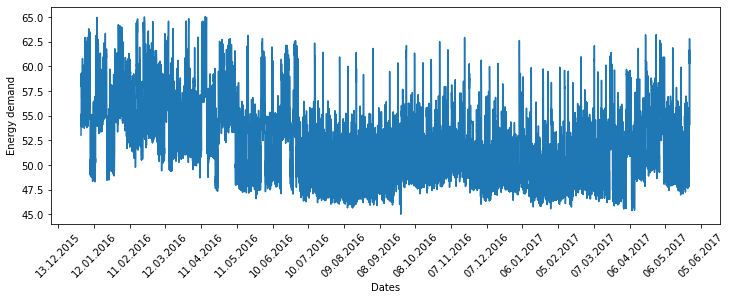

In [15]:
# Obtain name of the first building in our list
name = building_names[0]

# Get the dataframe for that building
bear_sidney = df[['timestamp', name]]

# Replace numeric index by the timestamp, s.t. that the dataframe only consists of an index row and the electricity values
bear_sidney = bear_sidney.set_index('timestamp')

# Interpolate missing values
bear_sidney = bear_sidney.fillna(bear_sidney.interpolate())

# Plot dates on the x axis
x = DATES[:n_train]

plt.figure(figsize=(12,4))

plt.plot(x, bear_sidney.values[:n_train])

# set interval to show ticks on the x axis to 30 days 
plt.gca().xaxis.set_major_locator(DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel("Dates")
plt.ylabel("Energy demand")

plt.xticks(rotation=45)

plt.show()

## 4.1 Seasonal Decomposition

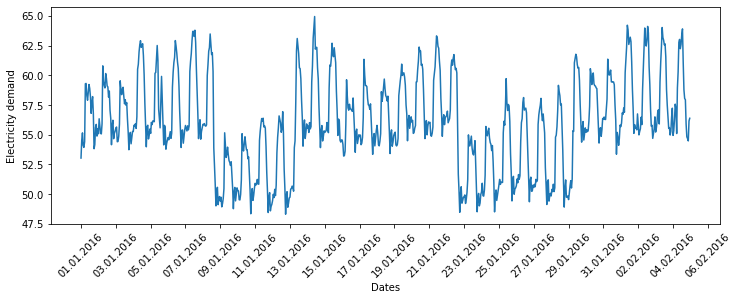

In [16]:
# Truncate the dataframe to the first 5 weeks and copy to new variable
df_bear = bear_sidney[: DATAPOINTS_ONE_WEEK*5].copy()

plt.figure(figsize=(12,4))
plt.plot(df_bear)

# set interval to show ticks on the x axis to 30 days 
plt.gca().xaxis.set_major_locator(DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.xlabel("Dates")
plt.ylabel("Electricity demand")

plt.show()

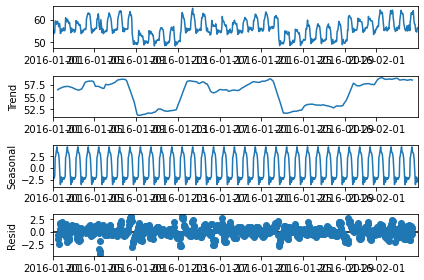

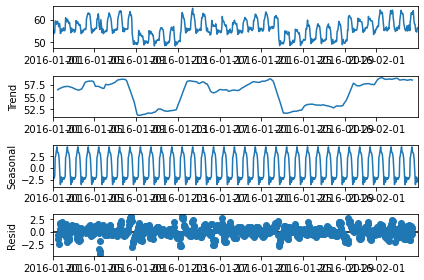

In [17]:
# Perform seasonal decomposition on the 5 week dataset
# For further detail on the seasonal decomposition visit: 
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

result = seasonal_decompose(df_bear)
result.plot()

Regarding the seasonal decomposition of a single timeseries, a strong seasonality of one day is visible.
There is a considerable trend in the data. The trend however is not just simply upward or downward, but it seems that it differs over time and also shows a somewhat oscillating behaviour. 

## 4.2 Analysis of Autocorrelation

C:\Users\marku\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


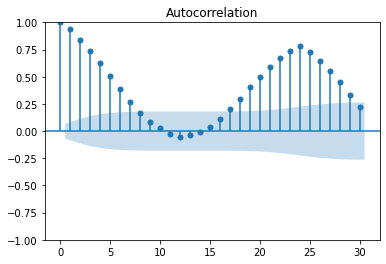

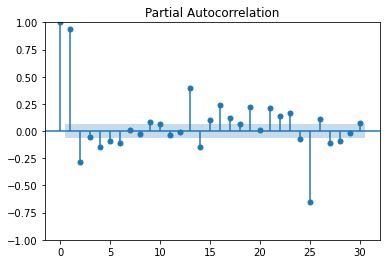

In [18]:
# Perform Autocorrelation and Partial Autocorrelation analysis on the 5 week dataset
# For further detail on the Correlation computation visit: 
# https://www.statsmodels.org/dev/graphics.html#time-series-plots

# Autocorrelation analysis
autocorrelation = plot_acf(df_bear)

# Partial Autocorrelation
partial_autocorrelation = plot_pacf(df_bear)

Regarding the Autocorrelation plot one can see a clear cyclic correlation within one day (within 24 datapoints). That the datapoints temporal close to the current show high correlation up until a lag of 5 hours, then they drop and show little or even anti correlation and for datapoints around the same time a day ago, e.g. a lag of 22 to 26 show high correlation again. 

Regarding the Partial Autocorrelation plot, one can see that the value with lag of 1h shows the highest correlation and a clear spike at a lag of 25 is noticable, which indicates a strong correlation to the values a day ago. 

This arouses the question of the best parameters for the ARIMA model. The autocorrelation plots indicate p,q values of either 1 or 24.

## 4.3. Check for Stationarity of the data

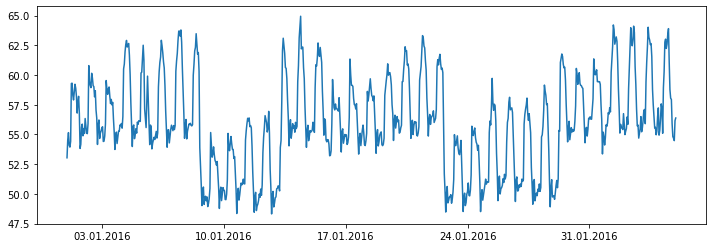

ADF test statistic: -1.3448093769799199
ADF p-values: 0.6084309727650498
ADF number of lags used: 21
ADF number of observations: 818
ADF critical values: {'1%': -3.438369485934381, '5%': -2.865079774912655, '10%': -2.5686548826226527}
ADF best information criterion: 2413.5188013091006
The series is NOT stationary


In [19]:
# Plot differenced timeseries
plt.figure(figsize=(12,4))
plt.plot(df_bear)

plt.gca().xaxis.set_major_locator(DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

# Apply Dickey-Fuller test on the data
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_bear.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)


check_stationarity(df_bear)


#### Make data stationary by differencing

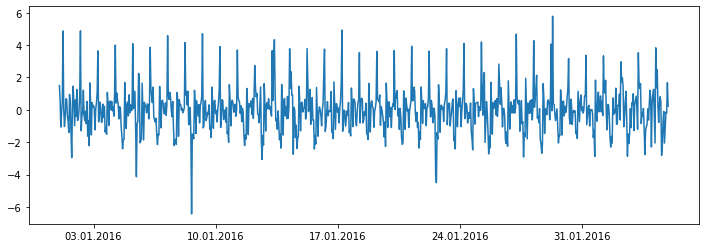

ADF test statistic: -16.253076529602758
ADF p-values: 3.6289550812660737e-29
ADF number of lags used: 21
ADF number of observations: 817
ADF critical values: {'1%': -3.438379332805805, '5%': -2.865084115496387, '10%': -2.5686571948451586}
ADF best information criterion: 2391.4380676242963
The series is stationary


In [20]:
# Shift the data by one s.t. that we create a new dataframe with a lag of 1 
prev_energy_value = df_bear.Bear_utility_Sidney.shift()

# Subtract from the original dataframe to obtain differenced energy time series
differenced_energy = df_bear.Bear_utility_Sidney - prev_energy_value


# Plot differenced timeseries
plt.figure(figsize=(12,4))
plt.plot(differenced_energy)

plt.gca().xaxis.set_major_locator(DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()


# Check for stationary
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_energy.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

check_stationarity(differenced_energy.dropna())

Regarding the results, we can clearly see that our data is not stationary by default, and therefore differencing should be applied to obtain stationarity. Therefore d=1 should be considered in the ARIMA models.

#  <a name="auto_arima"></a> 5. Parameter search for the SARIMA model

## 5.1. Check obtained parameters from pm.auto_arima

This function finds the best parameters combination for the SARIMA model with seasonality of m, by testing multiple combinations and looking for the best results.
For further details check the documentation of the [pmdarima library](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

Note that using auto_arima for each individual building would probably yield the best results. But training on the whole trainig period is not feasible on my local machine due to RAM limitations, and it is temporally very expensive. Therefore I used a smaller subset of only 5 weeks for the auto_arima function to make it feasible. 

#### Train on the  5 weeks dataset of the first building  'Bear_utility_Sidney' (following named  'df_bear') and predict for one day using the auto_arima model

In [21]:
pred_horizon = DATAPOINTS_ONE_DAY

# The number of datapoints of the training period
df_bear_train = df_bear.shape[0]

# The number of datapoints of the train and test period
df_bear_train_n_test = df_bear_train + pred_horizon

In [22]:
# Either fit the model, which takes quite some time or load it from the models

if (FIT_MODEL):
    model = pm.auto_arima(df_bear, seasonal=True, m=24)
    
    # TODO change names once we have a final structure
    # Pickle/save the model on the harddrive
    with open ('models/auto_arima_model_Bear_utility_Sidney.pkl', 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
            
# Load the model form the hardrive
else:  
    # TODO change names once we have a final structure
    with open('models/auto_arima_model_Bear_utility_Sidney.pkl', 'rb') as inp:
        model = pickle.load(inp)
        

# Make a prediction based on the model
bear_prediction = model.predict(pred_horizon)

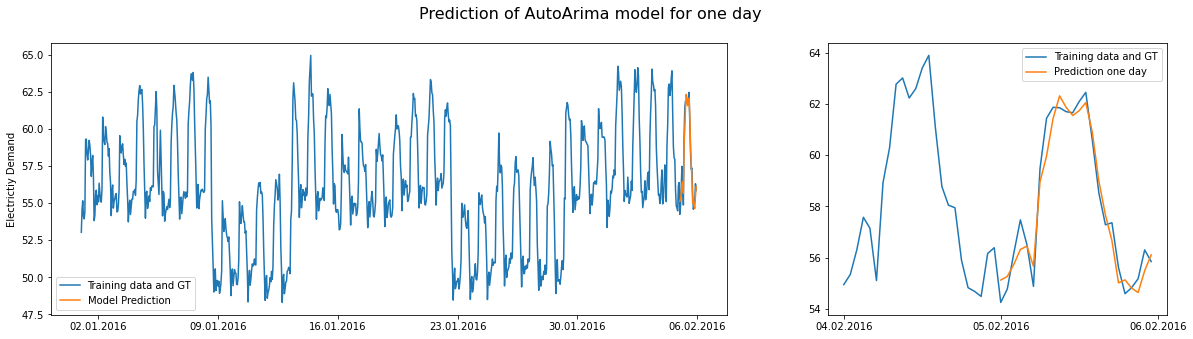

In [23]:
# The date for the x axis of the left plot, which shows more of the training data
x_left_plot = DATES[:df_bear_train_n_test]

# Truncate the dates for x axis on one day before the prediction and the predicted day
x_right_plot  = DATES[(df_bear_train - pred_horizon) : df_bear_train_n_test]

fig = plt.figure(figsize=(20, 5))
grid = GridSpec(1, 2, width_ratios=[2, 1])

# Plot the predicted values and the 5 week training period
ax0 = plt.subplot(grid[0])
ax0.plot(x_left_plot, bear_sidney.values[:df_bear_train_n_test], label='Training data and GT')
ax0.plot(x_left_plot[df_bear_train:], bear_prediction, label='Model Prediction')
ax0.xaxis.set_major_locator(DayLocator(interval=7))
ax0.xaxis.set_major_formatter(formatter)
ax0.set_ylabel('Electrictiy Demand')
ax0.legend()



# Plot a more detailed section of the predicted time period 
ax1 = plt.subplot(grid[1])
ax1.plot(x_right_plot, bear_sidney.values[(df_bear_train - pred_horizon) : df_bear_train_n_test], label='Training data and GT')
ax1.plot(x_right_plot[-pred_horizon:], bear_prediction, label='Prediction one day') 
ax1.xaxis.set_major_locator(DayLocator(interval=1))
ax1.xaxis.set_major_formatter(formatter)
ax1.legend()

fig.suptitle("Prediction of AutoArima model for one day", fontsize=16)
plt.show()

In [24]:
ground_truth_bear_sidney = bear_sidney.values[df_bear_train : df_bear_train_n_test]

print("MAE: " , mean_absolute_error(ground_truth_bear_sidney , bear_prediction))
print("RMSE: ", math.sqrt(mean_squared_error(ground_truth_bear_sidney  , bear_prediction)))

MAE:  0.5154271028405173
RMSE:  0.6115996098397475


The model performance of the auto_arima model is quite accurate and yields good results as the MAE and the RMSE are below 1. A closer look into the model parameters, which can be seen in the next cell reveal that the model only includes 1 lag and does not do differncing as the parameter value for d is 0. 

In [25]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 24),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

### Predict with the same model for one week and check the results

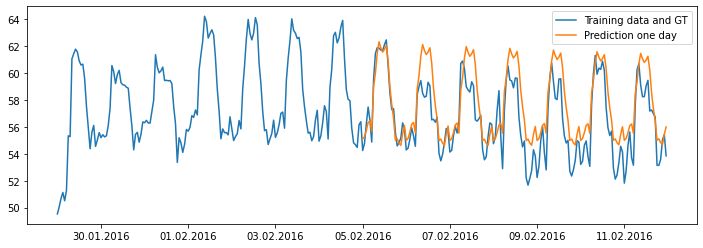

In [26]:
prediction_one_week = model.predict(DATAPOINTS_ONE_WEEK)

# Truncate the dates for x axis on one day before the prediction and the predicted day
x = DATES[(df_bear_train - DATAPOINTS_ONE_WEEK) : (df_bear_train + DATAPOINTS_ONE_WEEK)]

plt.figure(figsize=(12,4))

# Plot a more detailed section of the predicted time period 
plt.plot(x, bear_sidney.values[(df_bear_train - DATAPOINTS_ONE_WEEK) : (df_bear_train + DATAPOINTS_ONE_WEEK)], label='Training data and GT')

# Plot the prediction
plt.plot(x[-DATAPOINTS_ONE_WEEK:], prediction_one_week, label='Prediction one day')

plt.gca().xaxis.set_major_locator(DayLocator(interval=2) )
plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()
plt.show()

In [27]:
ground_truth_bear_sidney_week = bear_sidney.values[df_bear_train : (df_bear_train + DATAPOINTS_ONE_WEEK)]

print("MAE: " , mean_absolute_error(ground_truth_bear_sidney_week , prediction_one_week))
print("RMSE: ", math.sqrt(mean_squared_error(ground_truth_bear_sidney_week  , prediction_one_week)))

MAE:  1.463845566145493
RMSE:  1.798595888587116


Even for a prediction of one week after only 5 weeks of training data the results seem to be qutie good and based on a visual inspection and regarding the MAE and RMSE values the results are good and at least for the RMSE value it beats the benchmark. The MAE value is 0.3 higher than the benchmark. Overall it seems that the parameters found by the auto_arima are quite well


## 5.2. Test ARIMA model with One-Hot encoded features

I encoded the temporal aspect as one-hot encoded features which contain for each day of the week a single feature as well as for each month. The feature generation is done in [Section 3. Specification of Constants](#constants) of this notebook

#### Load or fit the model

In [28]:
if FIT_MODEL:
    # Fit the model using auto_arima - best parameters are found automatically
    ohe_model = pm.auto_arima(y=train[:df_bear_train], X=ohe_features[:df_bear_train], seasonal=True, m=24,  suppress_warnings=True)
    with open ('models/auto_arima_model_Bear_utility_Sidney_one_hot_encoded.pkl', 'wb') as outp:
        pickle.dump(ohe_model, outp, pickle.HIGHEST_PROTOCOL)
else: 
    # Load the model
    with open('models/auto_arima_model_Bear_utility_Sidney_one_hot_encoded.pkl', 'rb') as inp:
            ohe_model = pickle.load(inp)    

#### Prediction for  one day

In [29]:
pred_horizon = DATAPOINTS_ONE_DAY

# Load the one hot encoded features for the upcomming prediction_horizon 
ohe_pred_features = ohe_features[df_bear_train : df_bear_train + pred_horizon]

# predict including one hot encoded features
ohe_predictions = ohe_model.predict(n_periods = pred_horizon, X = ohe_pred_features)

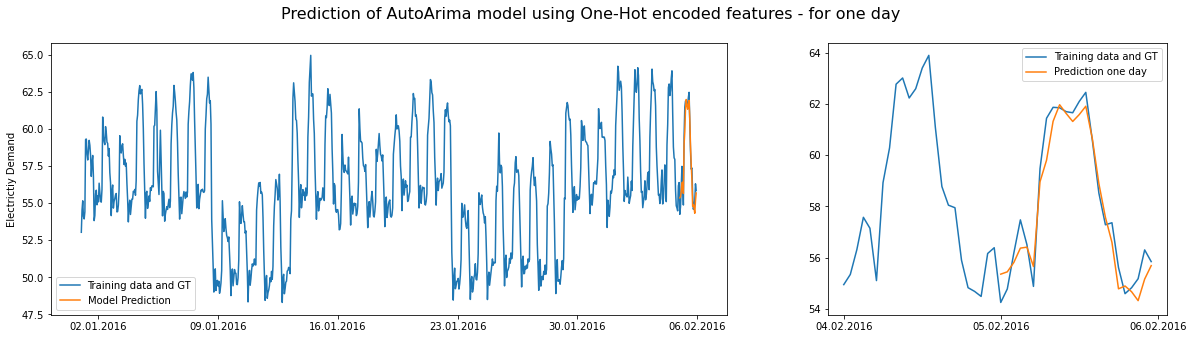

In [30]:
# The date for the x axis of the left plot, which shows more of the training data
x_left_plot = DATES[ : (df_bear_train + pred_horizon)]

# Truncate the dates for x axis on one day before the prediction and the predicted day
x_right_plot  = DATES[(df_bear_train - pred_horizon) : (df_bear_train + pred_horizon)]

fig = plt.figure(figsize=(20, 5))
grid = GridSpec(1, 2, width_ratios=[2, 1])

# Plot the predicted values and the 5 week training period
ax0 = plt.subplot(grid[0])
ax0.plot(x_left_plot , bear_sidney.values[: df_bear_train + pred_horizon], label='Training data and GT')
ax0.plot(x_left_plot[df_bear_train:] , ohe_predictions, label='Model Prediction')
ax0.xaxis.set_major_locator(DayLocator(interval=7))
ax0.xaxis.set_major_formatter(formatter)
ax0.set_ylabel('Electrictiy Demand')
ax0.legend()

# Plot a more detailed section of the predicted time period 
ax1 = plt.subplot(grid[1])
ax1.plot(x_right_plot, bear_sidney.values[(df_bear_train - pred_horizon) : df_bear_train_n_test], label='Training data and GT')
ax1.plot(x_right_plot[-pred_horizon:], ohe_predictions, label='Prediction one day') 
ax1.xaxis.set_major_locator(DayLocator(interval=1))
ax1.xaxis.set_major_formatter(formatter)
ax1.legend()


fig.suptitle("Prediction of AutoArima model using One-Hot encoded features - for one day", fontsize=16)
plt.show()

In [31]:
ground_trouth = bear_sidney.values[df_bear_train : df_bear_train + pred_horizon]

print("MAE: " , mean_absolute_error(ground_trouth,ohe_predictions))
print("RMSE: ", math.sqrt(mean_squared_error(ground_trouth,ohe_predictions)))

MAE:  0.5562142300776385
RMSE:  0.6855025598185751


#### Prediction for  one week

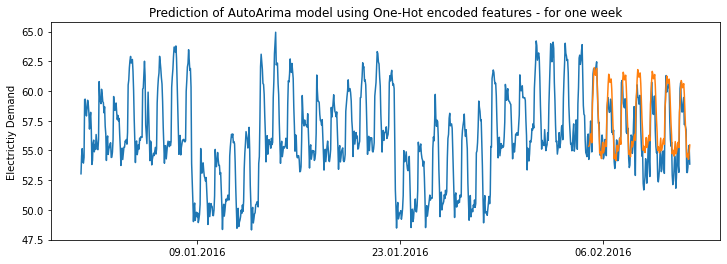

In [32]:
pred_horizon = DATAPOINTS_ONE_WEEK

# Load the one hot encoded features for the upcomming prediction_horizon 
ohe_pred_features = ohe_features[df_bear_train : df_bear_train + pred_horizon]

# predict including one hot encoded features
ohe_predictions = ohe_model.predict(n_periods = pred_horizon, X = ohe_pred_features)

x = DATES[:(df_bear_train + pred_horizon)]

plt.figure(figsize=(12,4))
plt.plot(x , bear_sidney.values[: df_bear_train + pred_horizon])
plt.plot(x[df_bear_train:] , ohe_predictions)

plt.gca().xaxis.set_major_locator(DayLocator(interval=14))
plt.gca().xaxis.set_major_formatter(formatter)
plt.ylabel('Electrictiy Demand')

plt.title("Prediction of AutoArima model using One-Hot encoded features - for one week")
plt.show()

In [33]:
ground_trouth = bear_sidney.values[df_bear_train : df_bear_train + pred_horizon]

print("MAE: " , mean_absolute_error(ground_trouth,ohe_predictions))
print("RMSE: ", math.sqrt(mean_squared_error(ground_trouth,ohe_predictions)))

MAE:  1.3895470671879147
RMSE:  1.7165363212127331


In [34]:
ohe_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 2, 24),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

# <a name="model_training_and_prediction"></a> 6. Train a model for each building to predict for one hour, day and week


The results from the auto_arima analysis on the timeseries of the first builiding resulted in a SARIMA model with order (1,0,1) and seasonal_orer (1,0,1,24). The second auto_arima model including one-hot encoded features had the parameters (1,0,1) as order and (2,0,2,24) for seasonal_order. The computational time for the first model was way faster as well as the required RAM and disk space which was smaller. This was the reason while I initially choose the first model with (1,0,1) and (1,0,1,24) to train and predict. 

In the following section you find the first iteration on the buildings and the forecasting based on the first model including one-hot encoded features.


For those models that did not manage to meet the benchmark I then trained on the second model which can be foudn in [Section 8](#reanalysis). 

In [36]:
pred_horizons = [DATAPOINTS_ONE_HOUR, DATAPOINTS_ONE_DAY ,DATAPOINTS_ONE_WEEK]

# Split into test and train set and store the number of elements and the corresponding dates into variables
df_train, df_test = train_test_split(df, train_size=0.7)

# get the ohe features for training
ohe_features_train = ohe_features[:n_train]
ohe_features_test = ohe_features[n_train:]

*********** Bear_utility_Sidney **************
MAE:  0.4987069313439605
MSE:  0.24870860337050973
RMSE: 0.4987069313439605


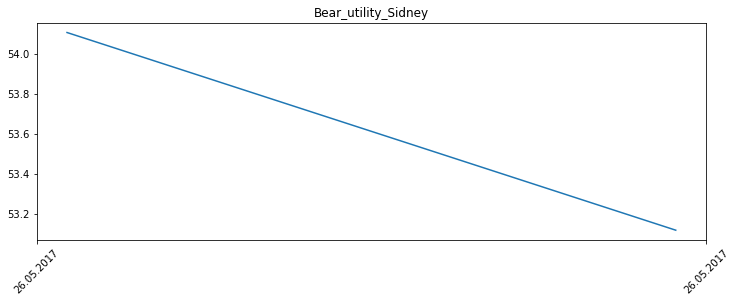

MAE:  1.3721679108806384
MSE:  3.1708347450354446
RMSE: 1.780683785806858


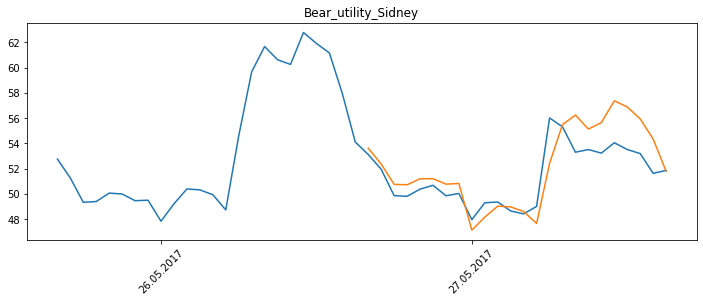

MAE:  1.709589072984325
MSE:  4.6105353048522755
RMSE: 2.1472157099025417


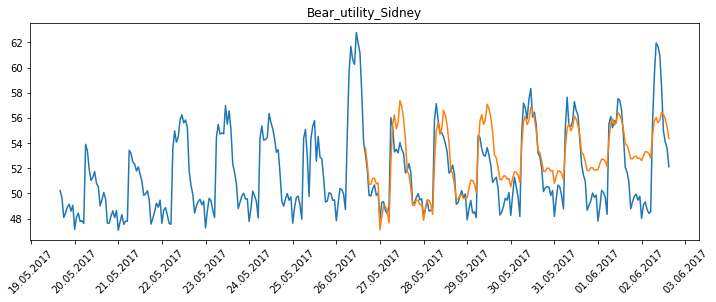

*********** Cockatoo_religion_Diedre **************
MAE:  0.2756877906950326
MSE:  0.07600375793830809
RMSE: 0.2756877906950326


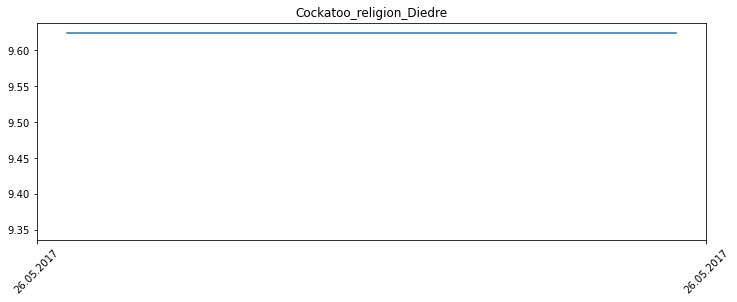

MAE:  3.297655808930499
MSE:  13.267889398494544
RMSE: 3.642511413639571


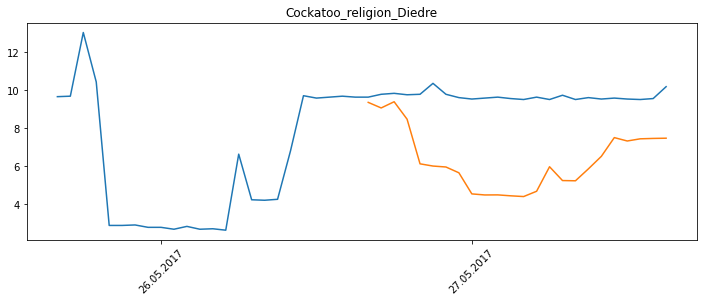

MAE:  3.3489384426496605
MSE:  12.55292196097785
RMSE: 3.543010296482054


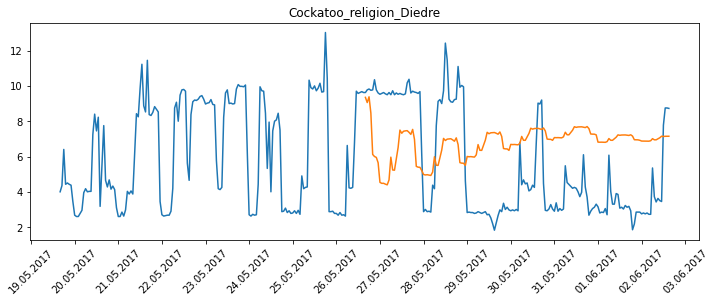

*********** Cockatoo_science_Rex **************
MAE:  2.2740953945511535
MSE:  5.171509863518766
RMSE: 2.2740953945511535


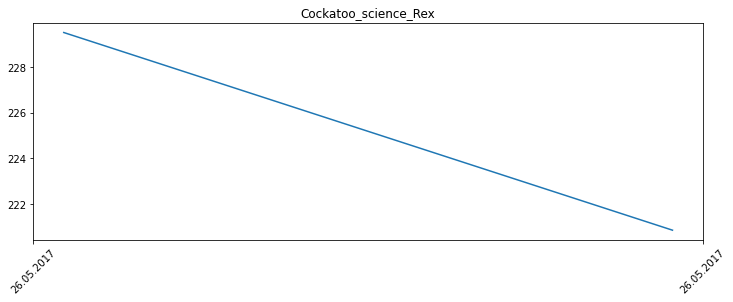

MAE:  11.670765993568233
MSE:  163.07840518704668
RMSE: 12.770215549748825


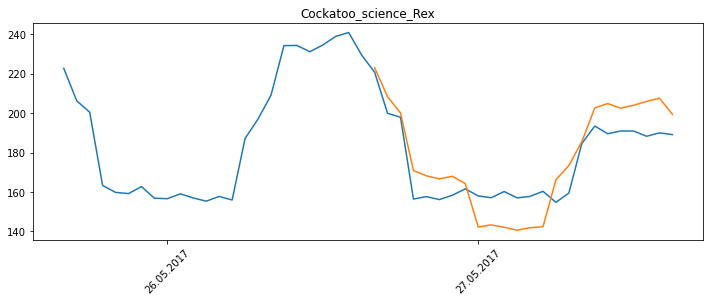

MAE:  12.545475274020722
MSE:  231.6902783294477
RMSE: 15.221375704234084


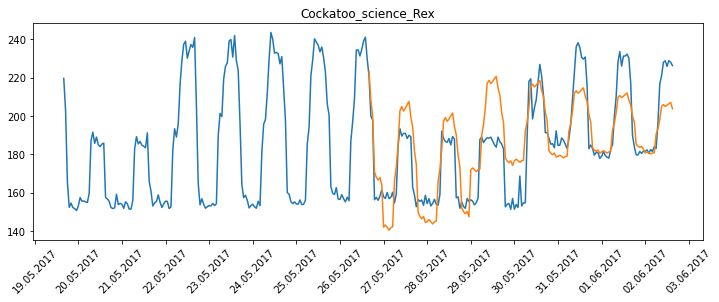

*********** Eagle_education_Teresa **************
MAE:  1.8569683498292164
MSE:  3.448331452267443
RMSE: 1.8569683498292164


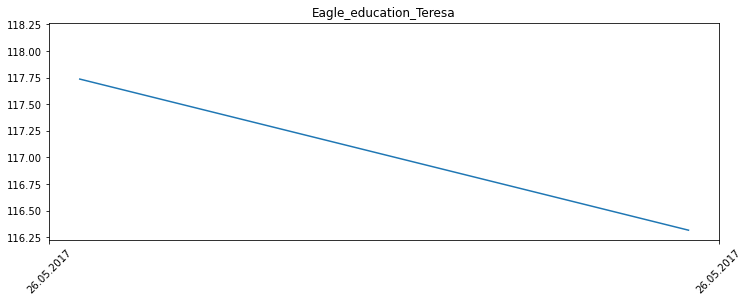

MAE:  5.950499382276923
MSE:  66.6996827490485
RMSE: 8.166987372896354


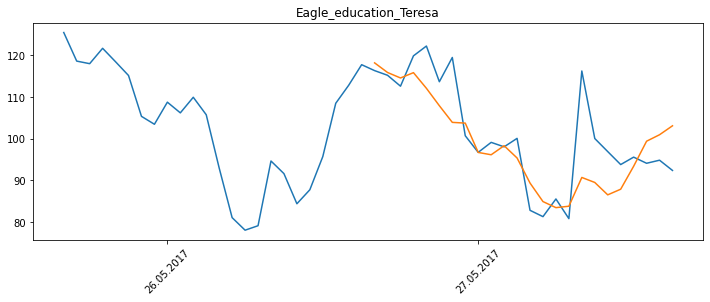

MAE:  8.357321322509726
MSE:  121.9967996283513
RMSE: 11.04521614221973


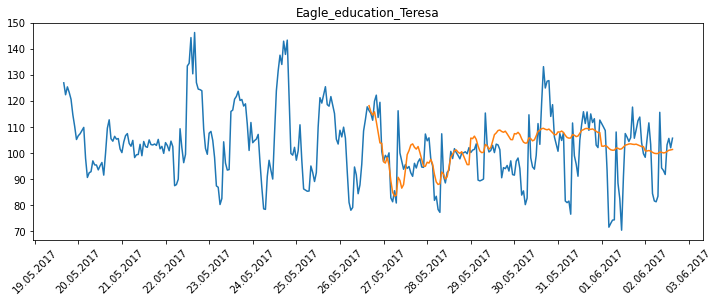

*********** Eagle_health_Lucinda **************
MAE:  18.257382941936726
MSE:  333.3320318885221
RMSE: 18.257382941936726


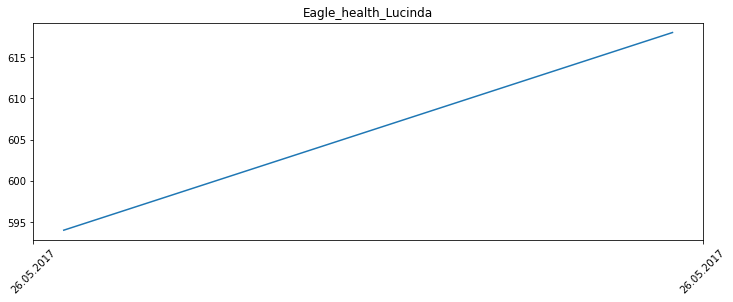

MAE:  25.247441792830088
MSE:  779.5397063318409
RMSE: 27.92023829289143


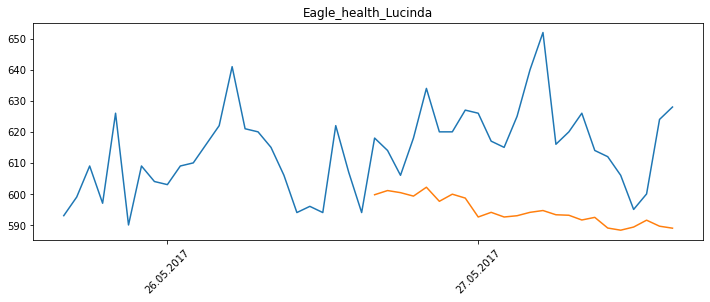

MAE:  54.88597576893471
MSE:  3456.5550197222856
RMSE: 58.79247417588654


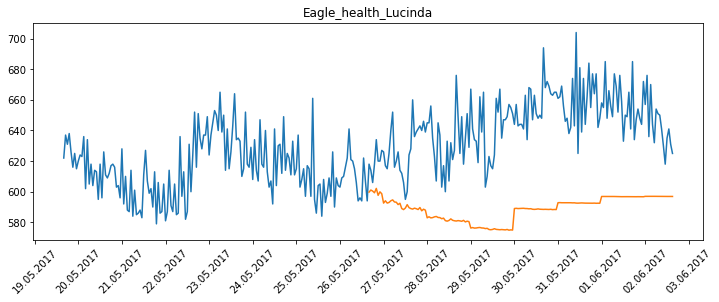

*********** Fox_food_Francesco **************
MAE:  3.1911763733456695
MSE:  10.18360664579962
RMSE: 3.1911763733456695


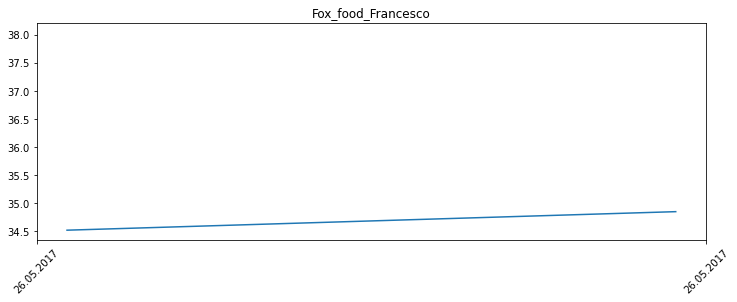

MAE:  5.739798633731174
MSE:  50.33065390951783
RMSE: 7.094410046615422


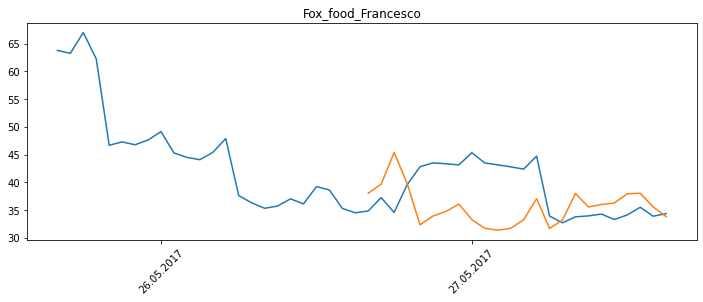

MAE:  6.977525566987359
MSE:  72.02587270406738
RMSE: 8.486805801010613


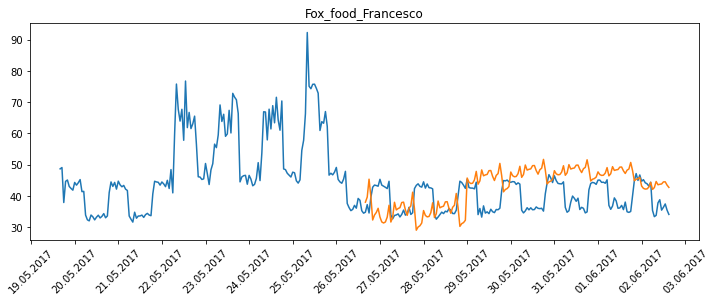

*********** Fox_parking_Tommie **************
MAE:  0.18497202857832917
MSE:  0.03421465135638222
RMSE: 0.18497202857832917


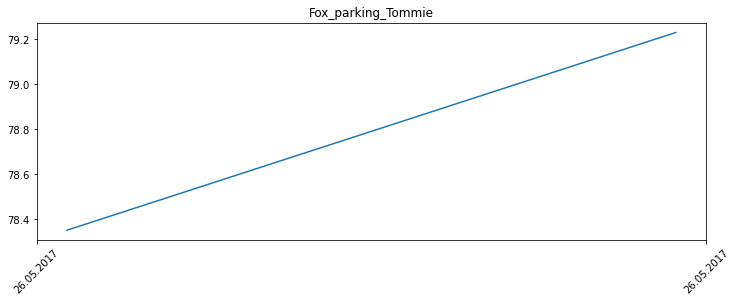

MAE:  1.1561949006773304
MSE:  2.030642851982594
RMSE: 1.425006263839775


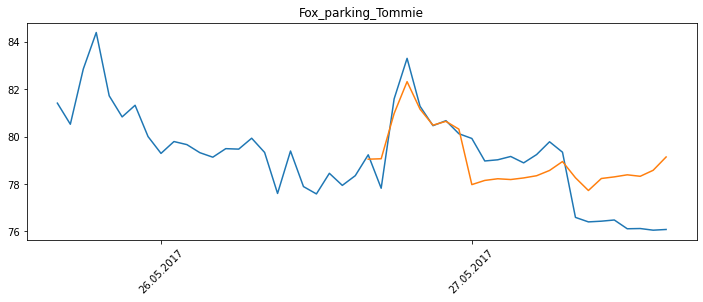

MAE:  7.599971776899299
MSE:  112.80275942500984
RMSE: 10.620864344534763


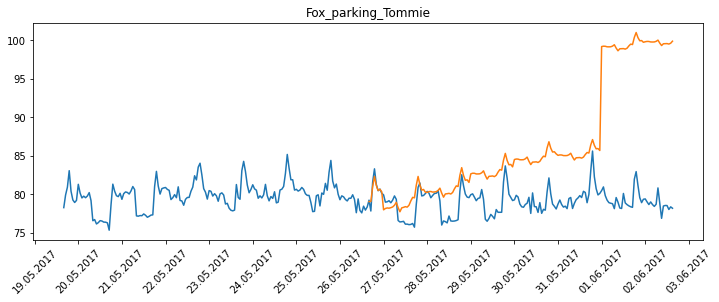

*********** Gator_other_Gertrude **************
MAE:  0.0031135760224434428
MSE:  9.69435564753473e-06
RMSE: 0.0031135760224434428


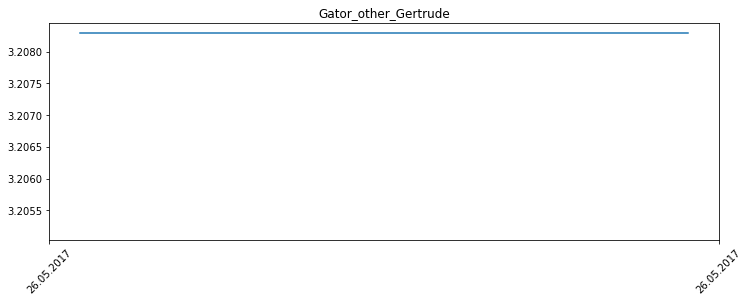

MAE:  0.05589050033292756
MSE:  0.004125066993656864
RMSE: 0.06422668443611942


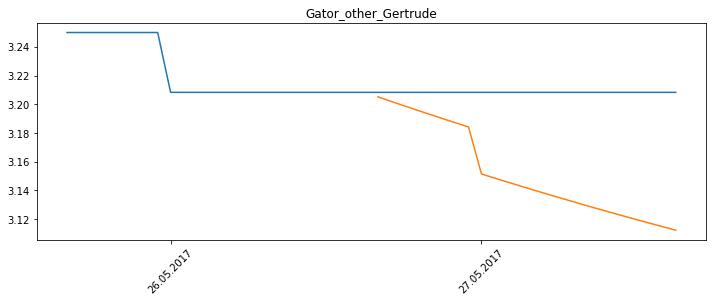

MAE:  0.9795186632985246
MSE:  1.4695582327392909
RMSE: 1.2122533698609754


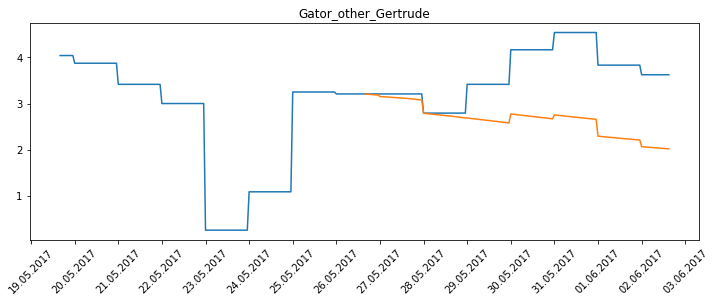

*********** Hog_office_Bill **************
MAE:  2.3842249408609177
MSE:  5.6845285686232465
RMSE: 2.3842249408609177


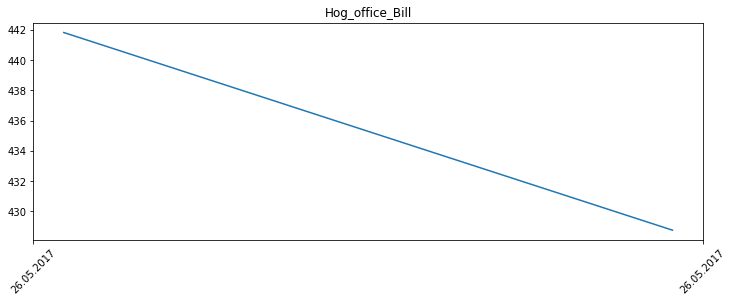

MAE:  22.683819816827253
MSE:  732.8919732655892
RMSE: 27.071977638613497


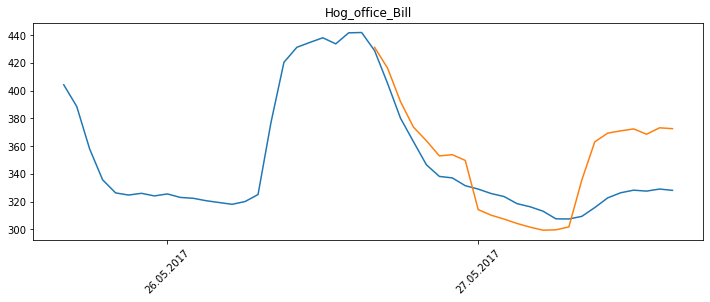

MAE:  38.92121823669721
MSE:  2304.536672533361
RMSE: 48.00559001338658


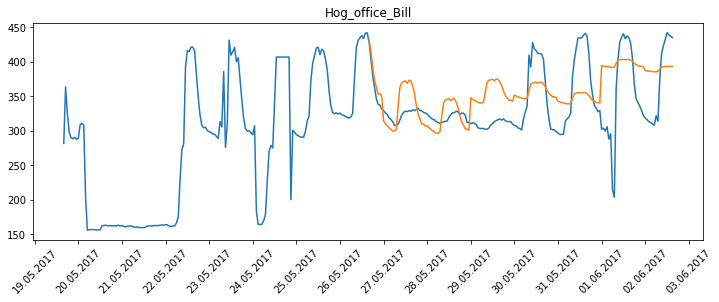

*********** Hog_services_Kerrie **************
MAE:  0.5785018206278565
MSE:  0.33466435646974463
RMSE: 0.5785018206278565


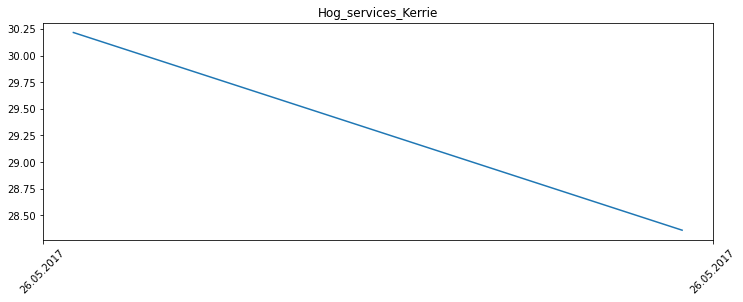

MAE:  3.1364077654366906
MSE:  11.972058503348045
RMSE: 3.460066257074862


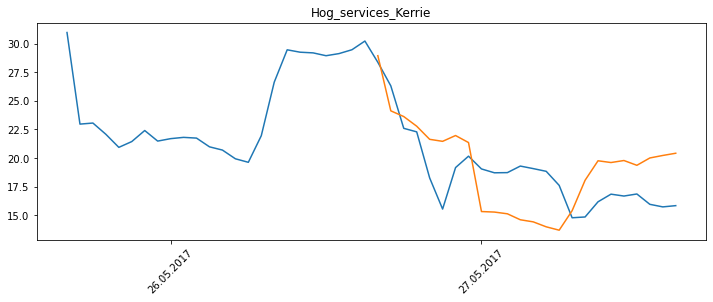

MAE:  3.9789456746074032
MSE:  26.285958499112947
RMSE: 5.126983372229029


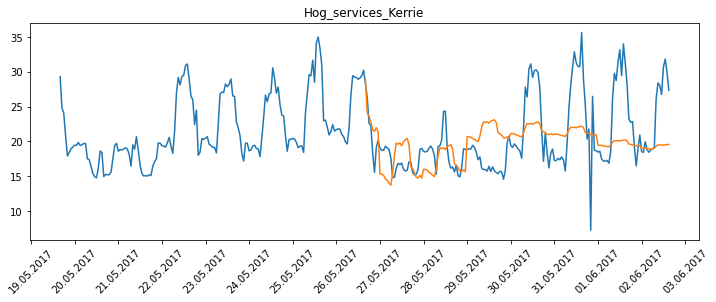

*********** Hog_warehouse_Porsha **************
MAE:  0.018660537270818955
MSE:  0.00034821565123562334
RMSE: 0.018660537270818955


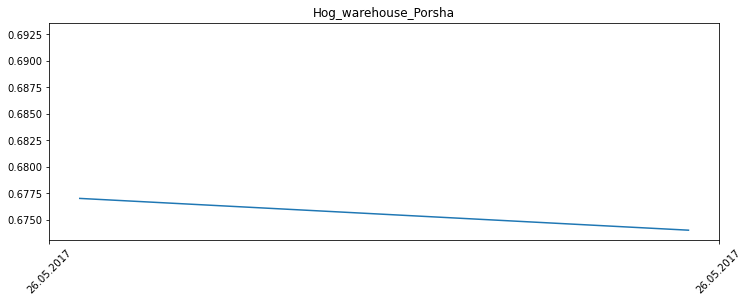

MAE:  0.42389712930911805
MSE:  0.892647393422926
RMSE: 0.9448001870358229


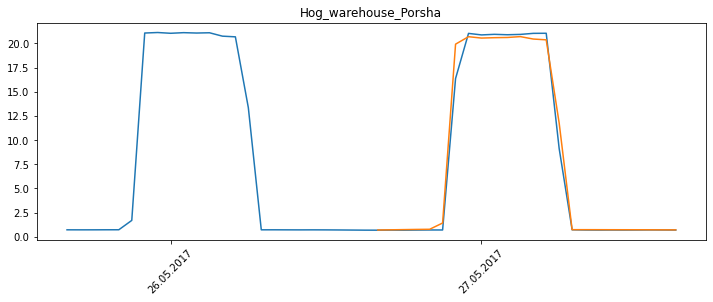

MAE:  0.7944832924165752
MSE:  3.780832323273939
RMSE: 1.9444362481896749


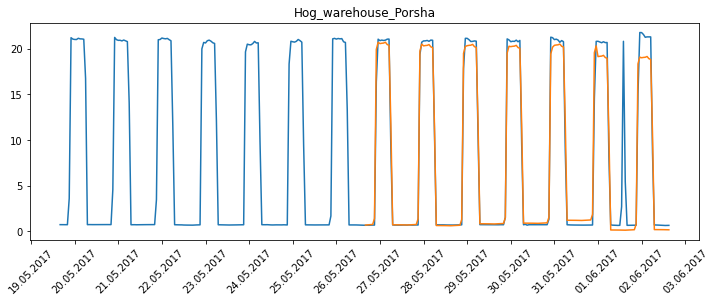

*********** Lamb_assembly_Bertie **************
MAE:  3.7562221343659274
MSE:  14.109204722700524
RMSE: 3.7562221343659274


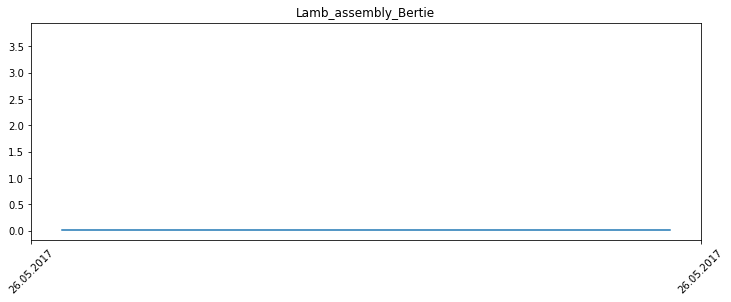

MAE:  28.912439481668702
MSE:  934.8105560028652
RMSE: 30.57467180531731


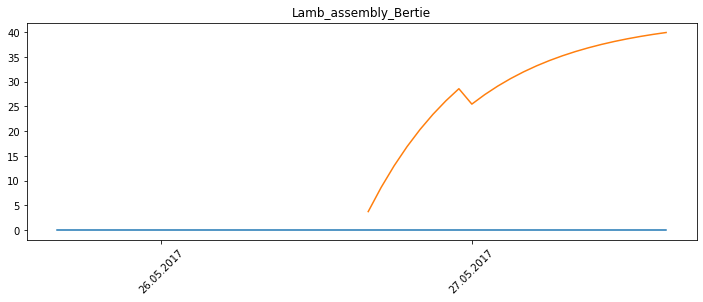

MAE:  62.06495431216908
MSE:  4554.125765867681
RMSE: 67.4842630979081


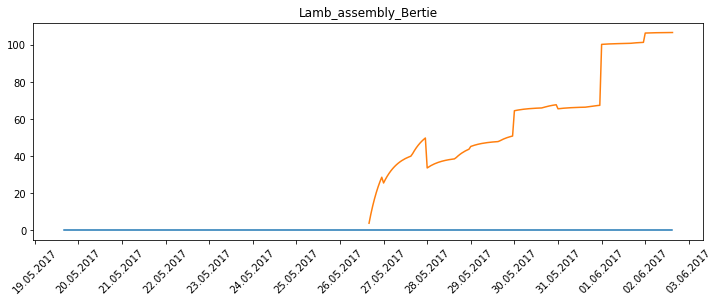

*********** Lamb_industrial_Carla **************
MAE:  6.2974386448182536
MSE:  39.65773348525036
RMSE: 6.2974386448182536


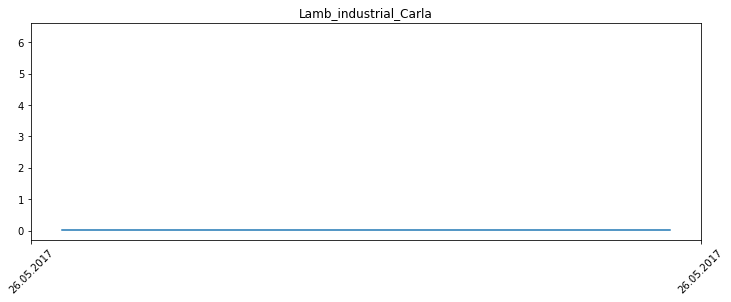

MAE:  44.046719344558234
MSE:  2368.790543787775
RMSE: 48.670222351945085


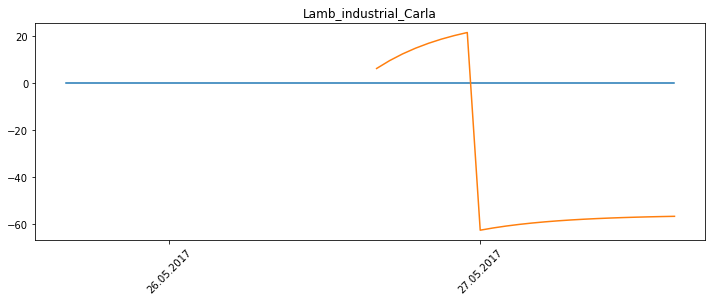

MAE:  95.54513307347958
MSE:  11533.960196758064
RMSE: 107.39627645667267


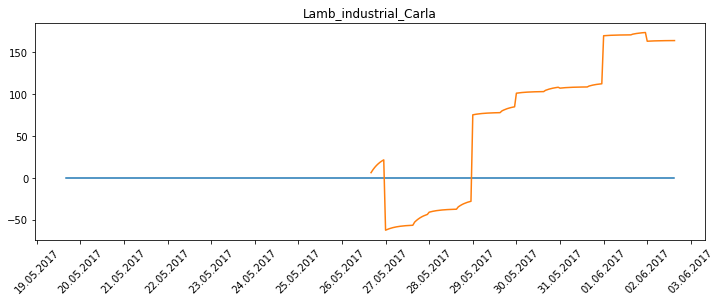

*********** Peacock_lodging_Matthew **************
MAE:  2.9268515107241058
MSE:  8.56645976582798
RMSE: 2.9268515107241058


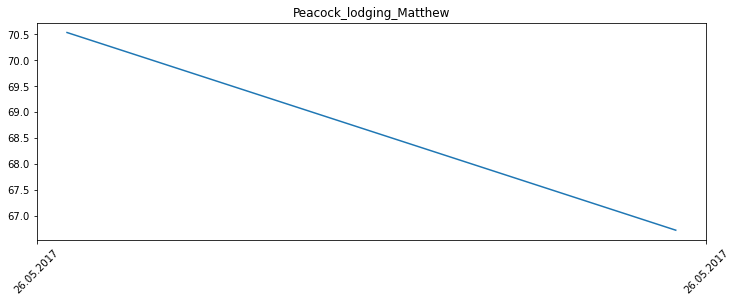

MAE:  5.059643925103254
MSE:  33.385204515003416
RMSE: 5.777993121751134


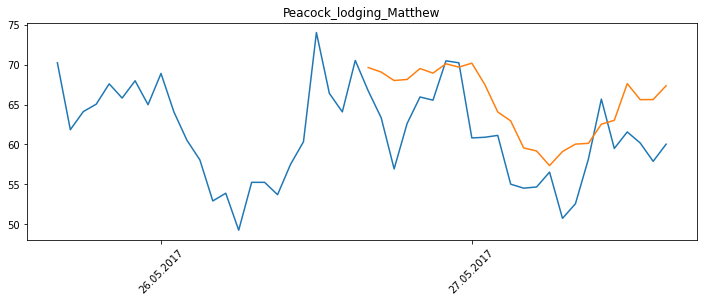

MAE:  11.712722135610338
MSE:  160.4828746922855
RMSE: 12.668183559306579


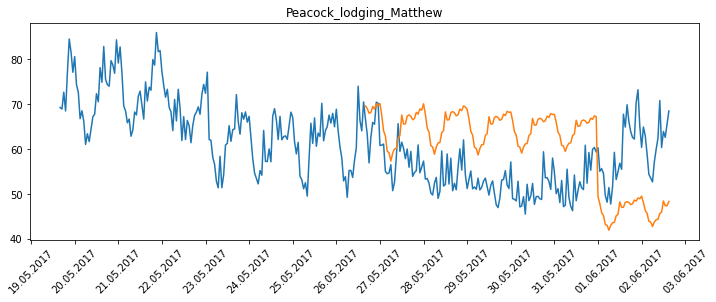

*********** Rat_public_Loretta **************
MAE:  1.4505012548204377
MSE:  2.1039538902356645
RMSE: 1.4505012548204377


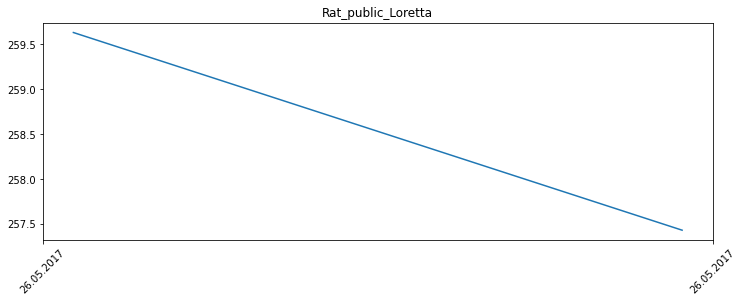

MAE:  5.031326496446734
MSE:  44.81415242906826
RMSE: 6.69433734054897


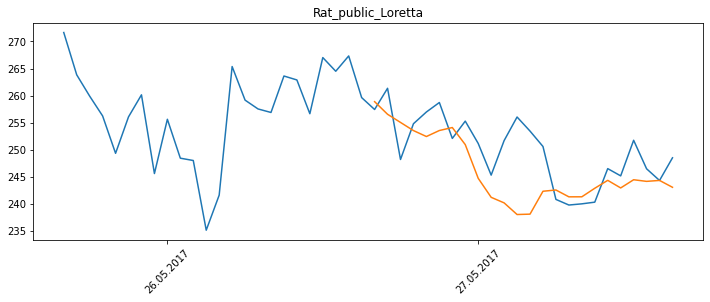

MAE:  15.609662219777151
MSE:  338.9958405510011
RMSE: 18.411839684045727


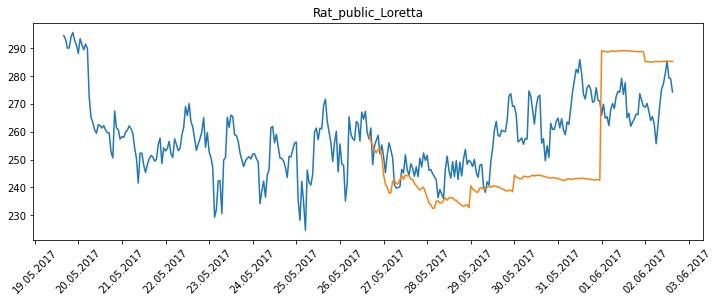

*********** Wolf_retail_Marcella **************
MAE:  1.6397553865973808
MSE:  2.688797727875126
RMSE: 1.6397553865973808


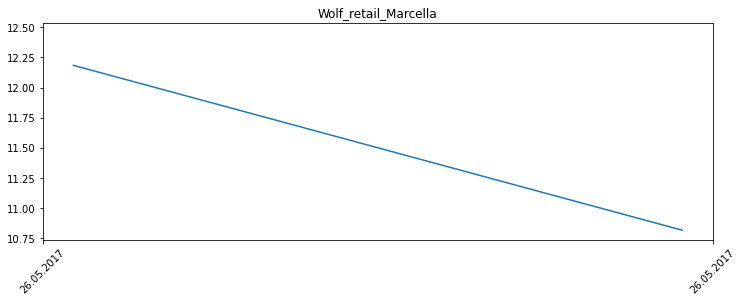

MAE:  0.9777875249992428
MSE:  1.321293415831103
RMSE: 1.1494752784775768


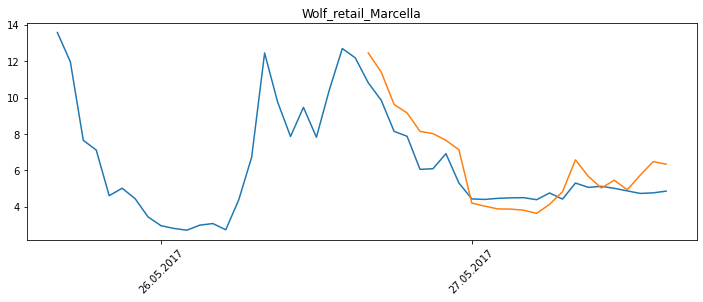

MAE:  2.1016898123222783
MSE:  7.753220349110904
RMSE: 2.7844605131175597


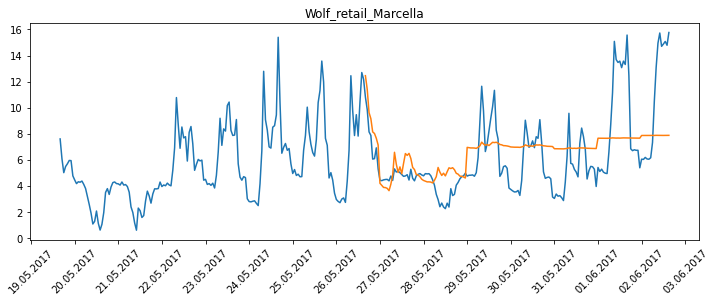

<IPython.core.display.Javascript object>

CPU times: total: 2min 1s
Wall time: 1min 41s


In [38]:
%%time
%%notify

errors =[]
predictions = []

# Specify the order and seasonal_order for the SARIMA model
order = (1,0,1)
seasonal_order = (1,0,1,24)

for name in building_names:
    print('*********** {} **************'.format(name))
    
    # Fetch the correct data according to name, interpolate missing values and split into train and test set
    df_temp = df[name]
    df_temp = df_temp.fillna(df_temp.interpolate())
    df_temp_train, df_temp_test = train_test_split(df_temp, train_size=0.7)
    
    
    # Either fit the model or load the already trained model
    if (FIT_MODEL):     
        model = pm.arima.ARIMA(order=order, seasonal_order=seasonal_order)   
        model.fit(y= df_temp_train, X=ohe_features_train)
        pickle_model(model, name, model.order, model.seasonal_order)
    else: 
        model = load_model(name, order, seasonal_order)
    
    
    
    for index, horizon in enumerate(pred_horizons):
        
        # Forecast according to the forecast horizon and load the ground truth
        temp_pred = model.predict(horizon, ohe_features_test[:horizon])
        temp_ground_trouth = df_temp_test[:horizon]

        # Error computation
        mae = mean_absolute_error(temp_ground_trouth, temp_pred)
        mse = mean_squared_error(temp_ground_trouth, temp_pred)
        rmse = math.sqrt(mse)
    
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("RMSE:", rmse)
        
        # Save errors and predictions 
        if (index == 0):
            errors.append((name, mae, mse, rmse, 'hourly'))
        if (index == 1):
            errors.append((name, mae, mse, rmse, 'daily'))
        if (index == 2):
            errors.append((name, mae, mse, rmse, 'weekly'))
            predictions.append((name, temp_pred, 'weekly'))

        # Plot the results
        plot_prediction(df_temp, temp_pred, name, horizon)
        
    # In order to avoid storage and RAM problems, release the storage space of the model before initialising a new one. 
    del(model)

In [39]:
with open ('models/_new_errors_sarima_order_1_0_1_seasonal_order_1_0_1_24_all.pkl', 'wb') as outp:
    pickle.dump(errors, outp, pickle.HIGHEST_PROTOCOL)
    
with open ('models/_new_predictions_sarima_order_1_0_1_seasonal_order_1_0_1_24_all.pkl', 'wb') as outp:
    pickle.dump(predictions, outp, pickle.HIGHEST_PROTOCOL)

# <a name="visualization_results"></a> 7. Visualize results

The results from the above trained models are preseted in this section. The individual predictions can be also be found above, as for each predictino a plot has been created, to allow a direct insight in the achieved error values. 
The results are preseneted according to the prediction horizons, first hourly, then daily and then weekly. 
For each of the buildings the defined benchmark values are marked as a horizontal, dotted line in the blot, whereas the bar plots, indicate, whether the achieved value is above or below the benchmark

## 7.1 Hourly results - comparison against benchmarks

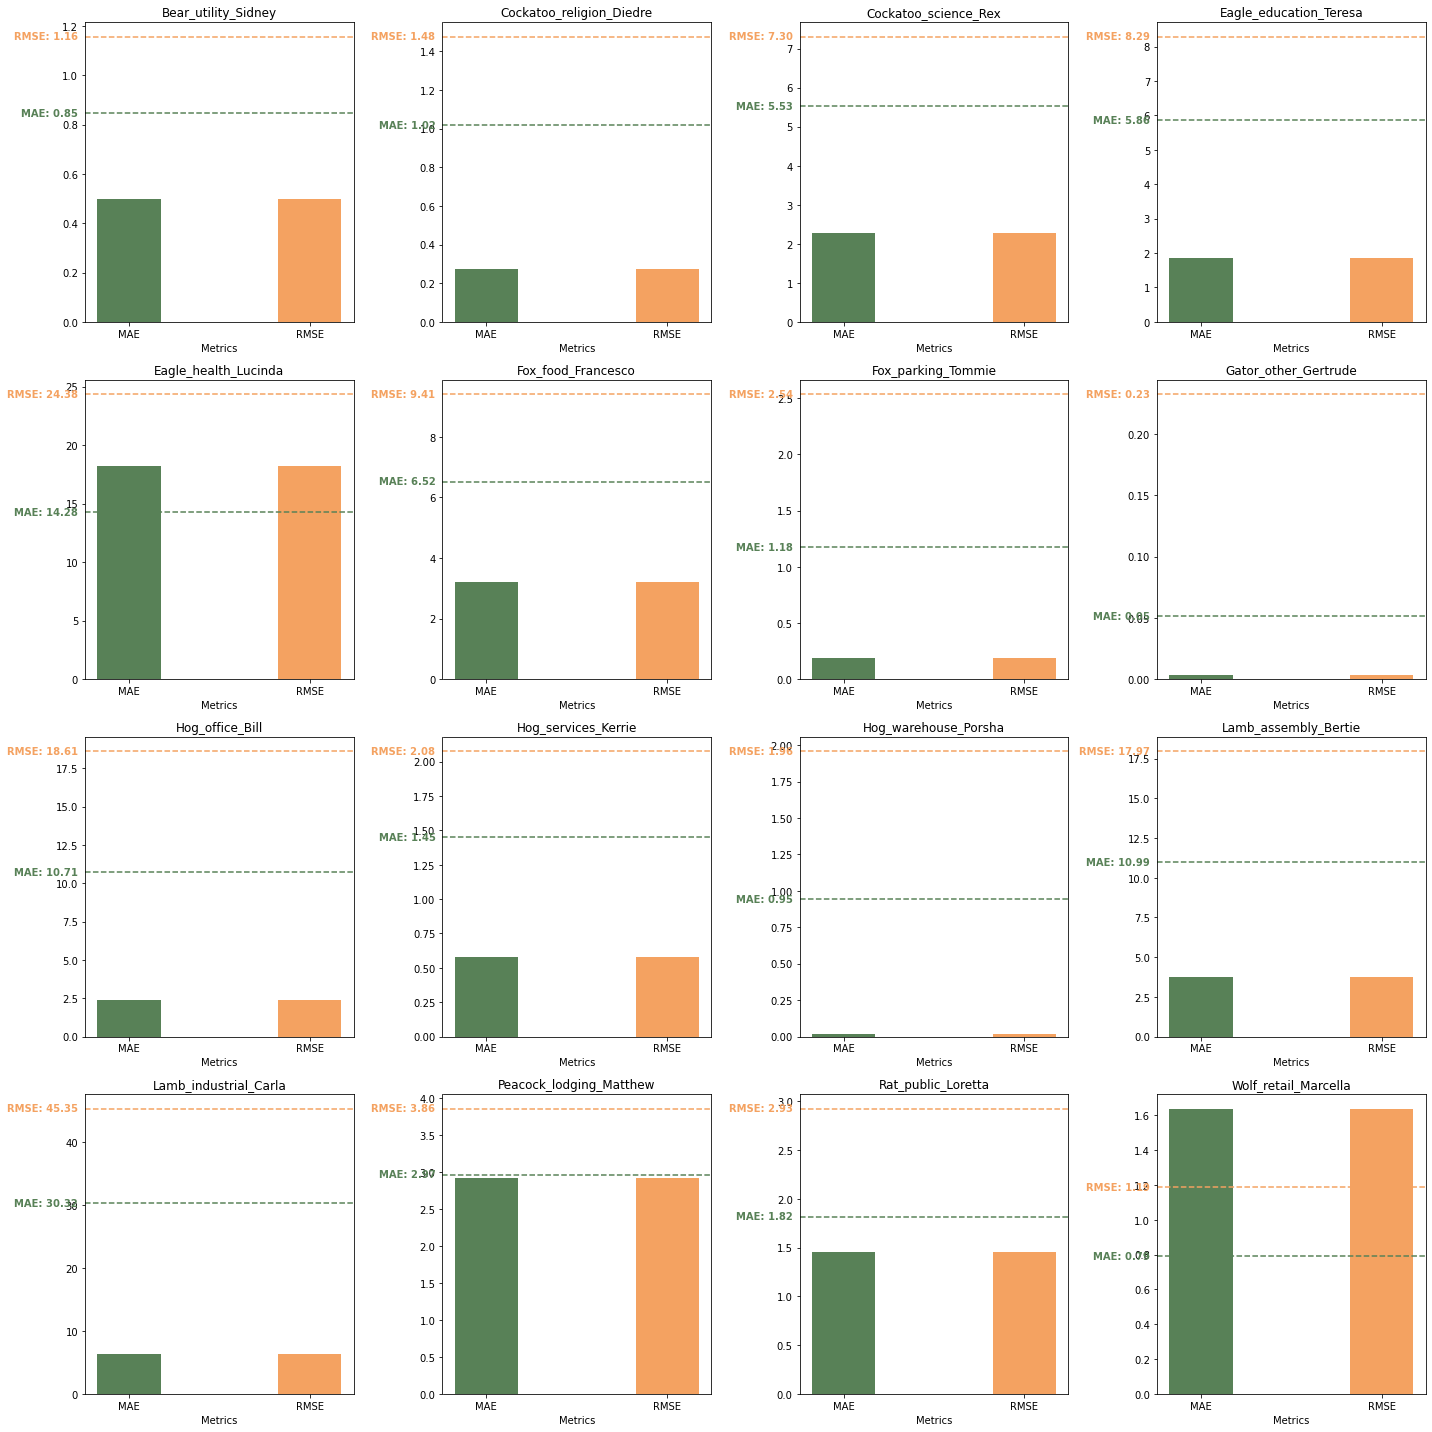

There are 2 buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough ['Eagle_health_Lucinda', 'Wolf_retail_Marcella']


In [59]:
# Create subplots with a single row and multiple columns
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

revisit_hourly = []

for i, name in enumerate(building_names): 
    bench_rmse = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'hourly')]['RMSE'].values[0]
    bench_mae = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'hourly')]['MAE'].values[0]
    
    error_entry = [err for err in errors if (err[0] == name) and (err[4] == 'hourly') ]
    obtained_mae = error_entry[0][1]
    obtained_rmse = error_entry[0][3]
    
    if (obtained_mae >= bench_mae or obtained_rmse >= bench_rmse): 
        revisit_hourly.append(name)
    
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    x  = np.arange(2)  # Two error metrics (MAE and RMSE)
    width = 0.35
    
    # Plot the bars for obtained values in green and orange
    ax.bar(x, [obtained_mae, obtained_rmse], width, color=colors)
    
    # Plot horizontal dashed lines for benchmark values with matching colors
    ax.axhline(bench_mae, color=colors[0], linestyle='--')
    ax.axhline(bench_rmse, color=colors[1], linestyle='--')
    
    
    # Annotate the MAE and the RMSE benchmarks values on the horizontal dashed lines 
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_mae, "MAE: {:.2f}".format(bench_mae), color=colors[0], transform=trans, 
        ha="right", va="center", weight='bold' )
    
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_rmse, "RMSE: {:.2f}".format(bench_rmse), color=colors[1], transform=trans, ha="right", va="center", weight='bold' )
    
    
    ax.set_xlabel('Metrics')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(['MAE', 'RMSE'])

plt.tight_layout()
plt.show()


print("There are {} buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough {}".format(len(revisit_hourly), revisit_hourly))

## 7.2 Daily results - comparison against benchmarks

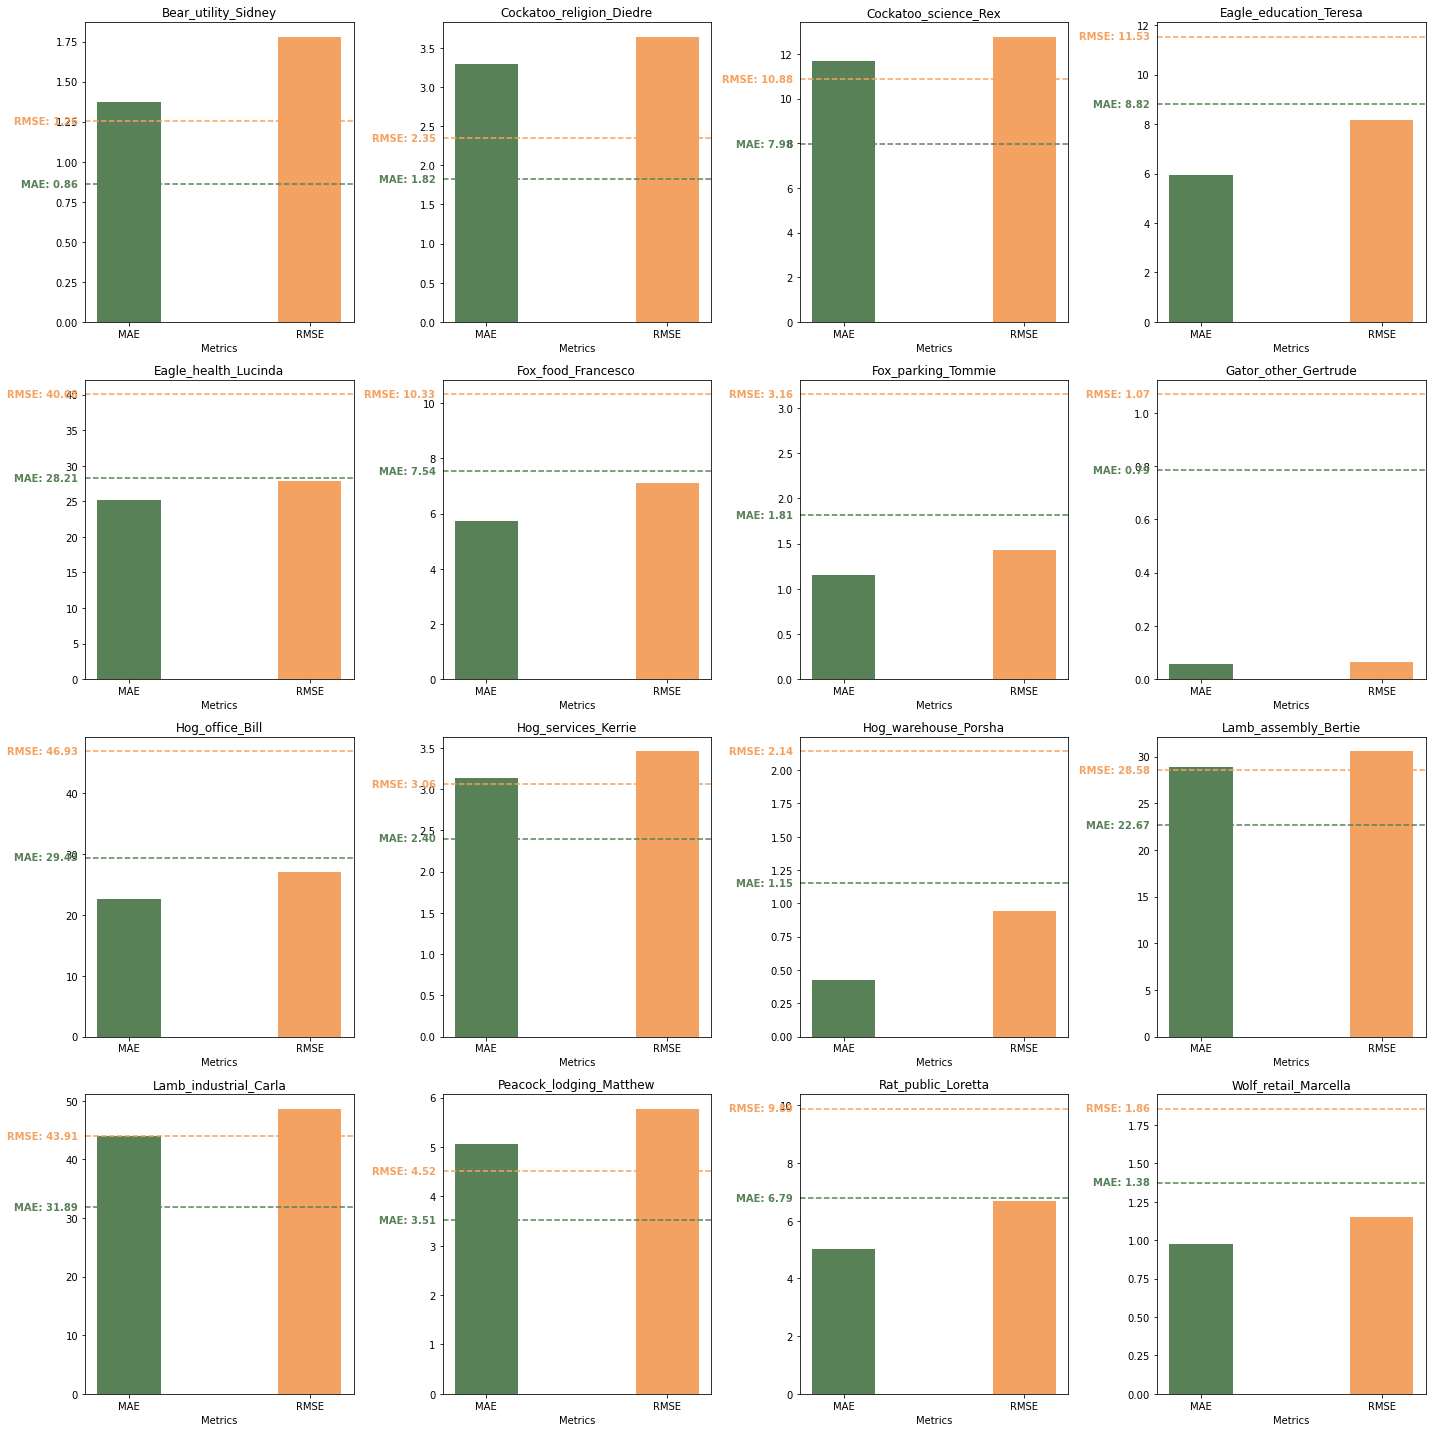

There are 7 buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough ['Bear_utility_Sidney', 'Cockatoo_religion_Diedre', 'Cockatoo_science_Rex', 'Hog_services_Kerrie', 'Lamb_assembly_Bertie', 'Lamb_industrial_Carla', 'Peacock_lodging_Matthew']


In [58]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

revisit_daily = []

for i, name in enumerate(building_names): 
    bench_rmse = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'daily')]['RMSE'].values[0]
    bench_mae = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'daily')]['MAE'].values[0]
    
    error_entry = [err for err in errors if (err[0] == name) and (err[4] == 'daily') ]
    obtained_mae = error_entry[0][1]
    obtained_rmse = error_entry[0][3]
    
    if (obtained_mae >= bench_mae or obtained_rmse >= bench_rmse): 
        revisit_daily.append(name)
    
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    x  = np.arange(2)  # Two error metrics (MAE and RMSE)
    width = 0.35
    
    # Plot the bars for obtained values in green and orange
    ax.bar(x, [obtained_mae, obtained_rmse], width, color=colors)
    
    # Plot horizontal dashed lines for benchmark values with matching colors
    ax.axhline(bench_mae, color=colors[0], linestyle='--')
    ax.axhline(bench_rmse, color=colors[1], linestyle='--')
    
    
    
    # Annotate the MAE and the RMSE benchmarks values on the horizontal dashed lines 
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_mae, "MAE: {:.2f}".format(bench_mae), color=colors[0], transform=trans, 
        ha="right", va="center", weight='bold' )
    
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_rmse, "RMSE: {:.2f}".format(bench_rmse), color=colors[1], transform=trans, ha="right", va="center", weight='bold' )
    
    
    ax.set_xlabel('Metrics')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(['MAE', 'RMSE'])

plt.tight_layout()
plt.show()


print("There are {} buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough {}".format(len(revisit_daily), revisit_daily))

## 7.3. Weekly results - comparison against benchmarks

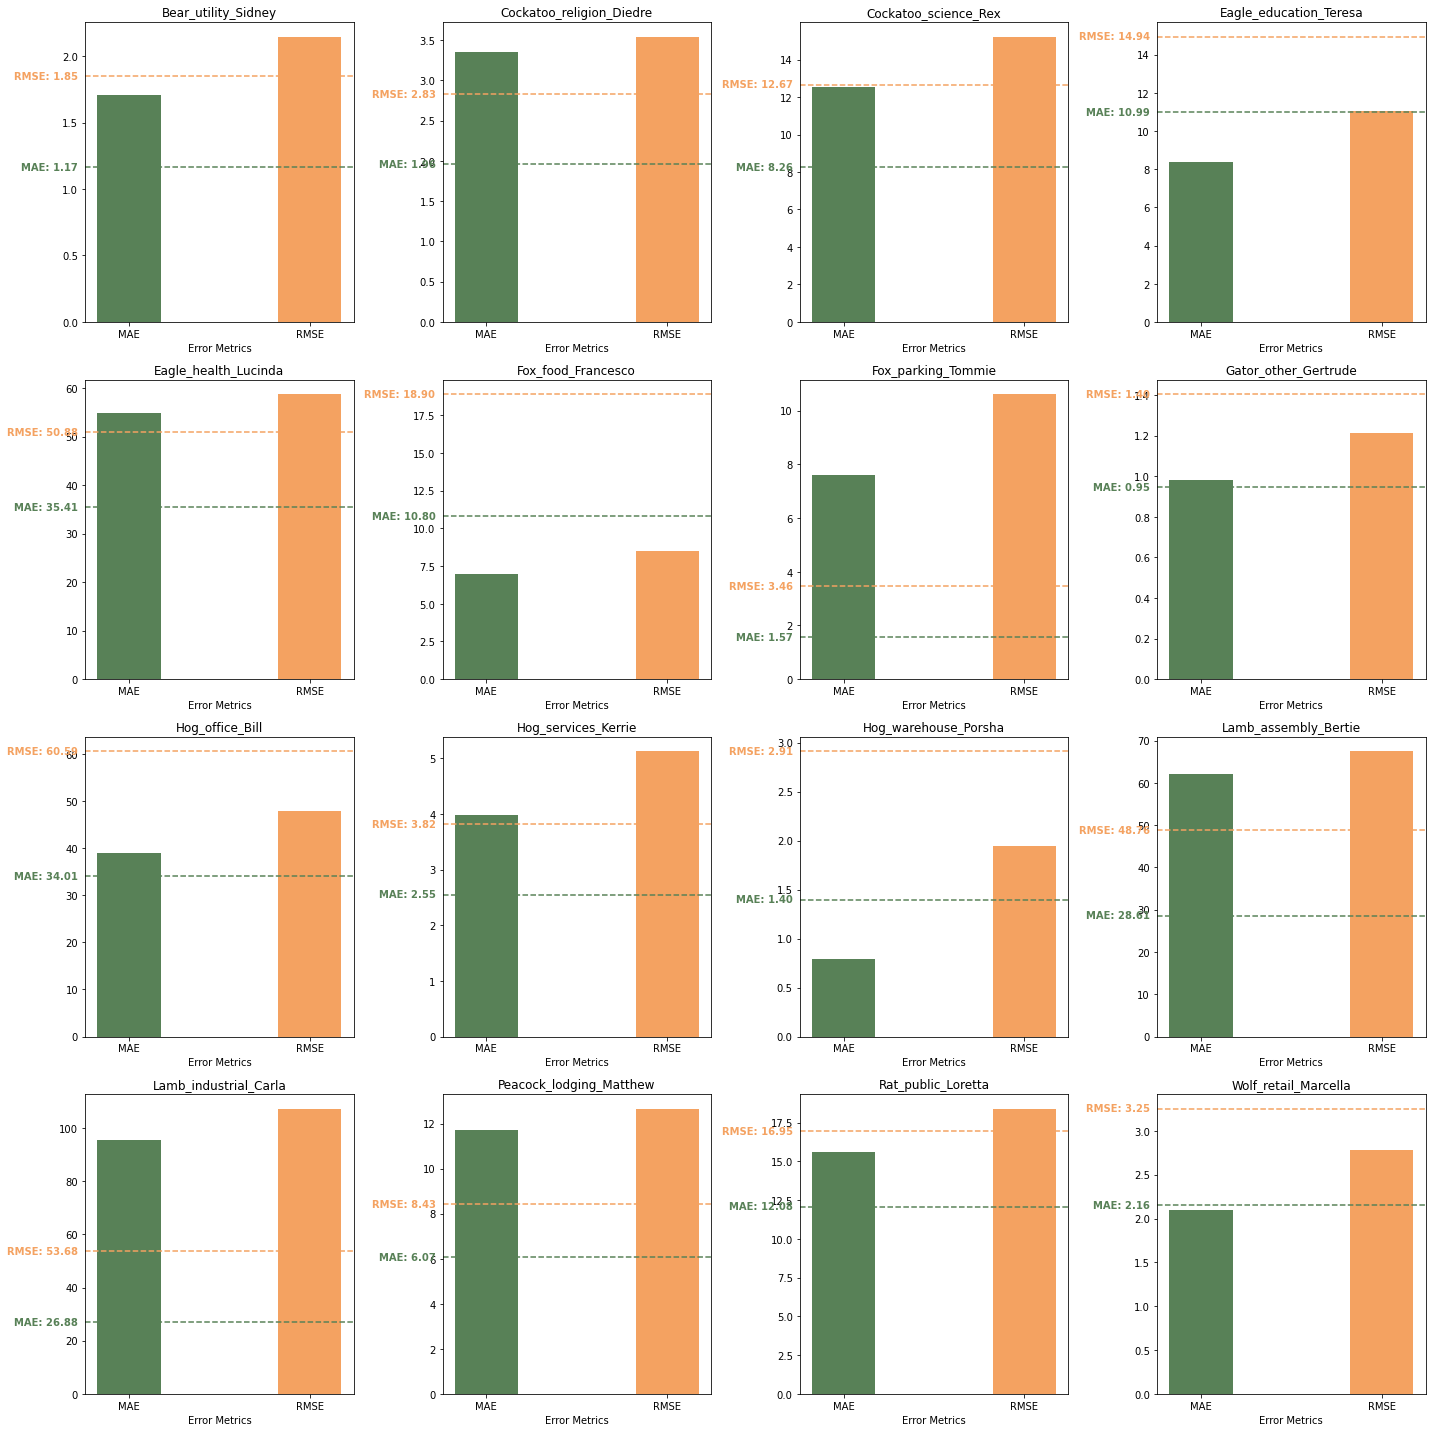

There are 12 buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough ['Bear_utility_Sidney', 'Cockatoo_religion_Diedre', 'Cockatoo_science_Rex', 'Eagle_health_Lucinda', 'Fox_parking_Tommie', 'Gator_other_Gertrude', 'Hog_office_Bill', 'Hog_services_Kerrie', 'Lamb_assembly_Bertie', 'Lamb_industrial_Carla', 'Peacock_lodging_Matthew', 'Rat_public_Loretta']


In [57]:
# Create subplots with a single row and multiple columns
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

revisit_weekly = []

for i, name in enumerate(building_names): 
    bench_rmse = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'weekly')]['RMSE'].values[0]
    bench_mae = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'weekly')]['MAE'].values[0]
    
    error_entry = [err for err in errors if (err[0] == name) and (err[4] == 'weekly') ]
    obtained_mae = error_entry[0][1]
    obtained_rmse = error_entry[0][3]
    
    if (obtained_mae >= bench_mae or obtained_rmse >= bench_rmse): 
        revisit_weekly.append(name)
    
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    x  = np.arange(2)  # Two error metrics (MAE and RMSE)
    width = 0.35
    
    # Plot the bars for obtained values in green and orange
    ax.bar(x, [obtained_mae, obtained_rmse], width, color=colors)
    
    # Plot horizontal dashed lines for benchmark values with matching colors
    ax.axhline(bench_mae, color=colors[0], linestyle='--', label='bench')
    ax.axhline(bench_rmse, color=colors[1], linestyle='--')
    
    
    # Annotate the MAE and the RMSE benchmarks values on the horizontal dashed lines 
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_mae, "MAE: {:.2f}".format(bench_mae), color=colors[0], transform=trans, 
        ha="right", va="center", weight='bold' )
    
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_rmse, "RMSE: {:.2f}".format(bench_rmse), color=colors[1], transform=trans, ha="right", va="center", weight='bold' )
    
    
    ax.set_xlabel('Error Metrics')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(['MAE', 'RMSE'])
    
    
    

plt.tight_layout()
plt.show()

print("There are {} buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough {}".format(len(revisit_weekly), revisit_weekly))

## 7.4 Visualize results - predictions for one week 

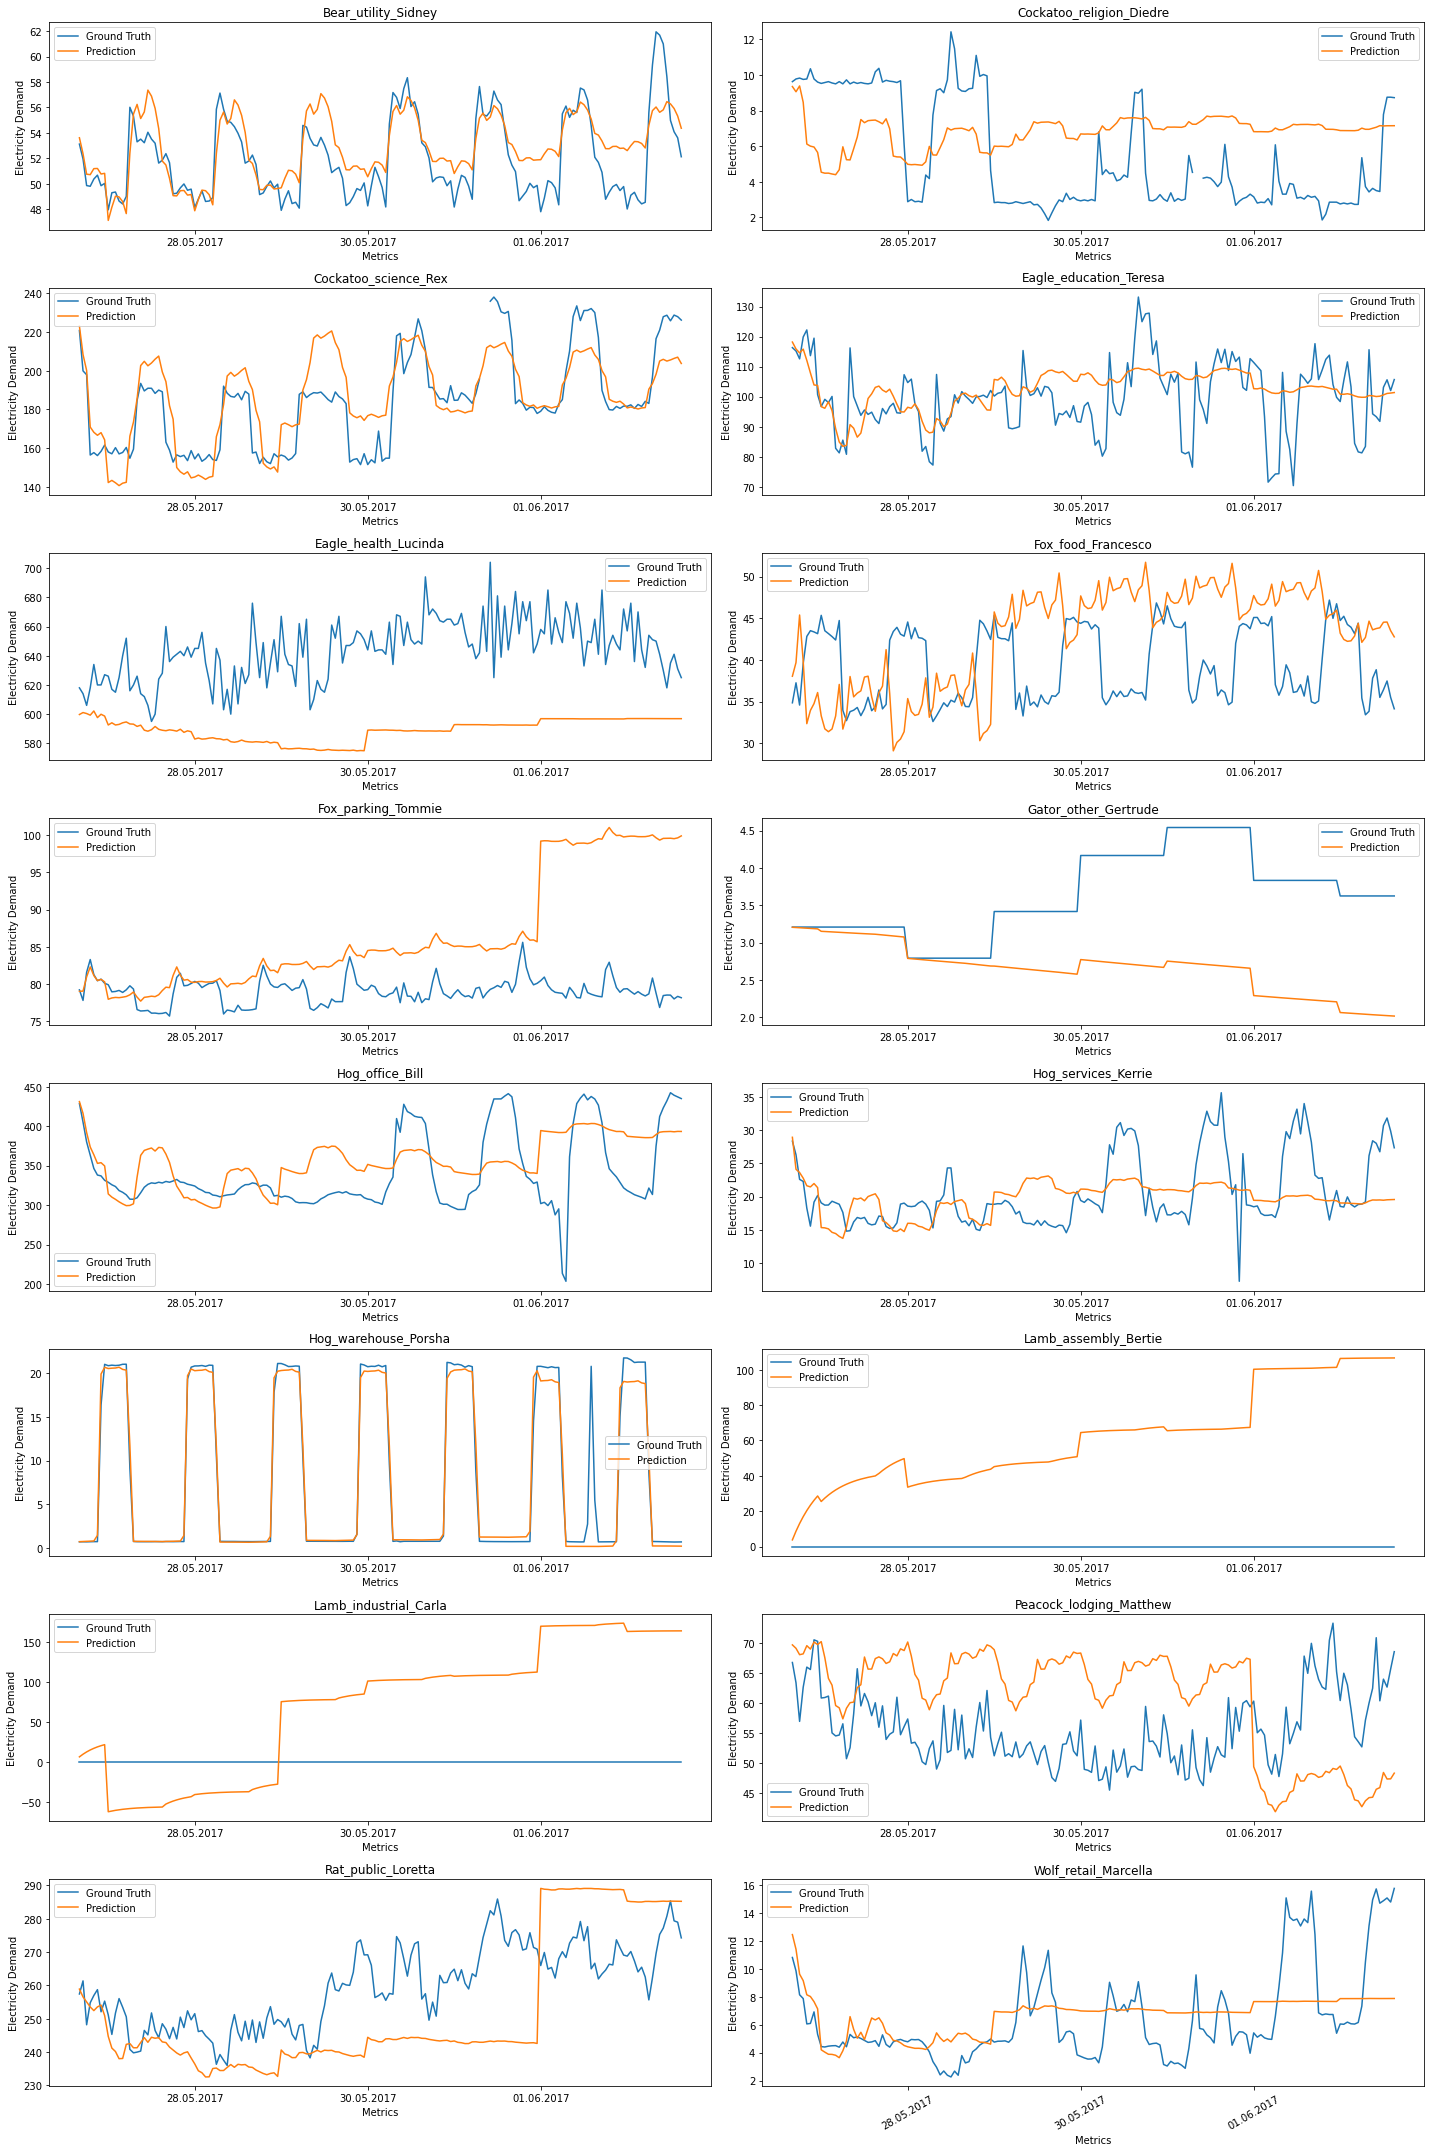

In [44]:
# Fetch the time for the predicted horizon ( one week after the training period)
x = DATES[n_train:(n_train + DATAPOINTS_ONE_WEEK)]

fig, axs = plt.subplots(8, 2, figsize=(20,30))

for i, name in enumerate(building_names): 

    # Fetch the actual electricity demand during the predicted week
    df_temp = df[name]
    ground_truth = df_temp[n_train: n_train + DATAPOINTS_ONE_WEEK]

    # Load the prediction
    prediction_entry = [p for p in predictions if p[0] == name]
    pred = prediction_entry[0][1]
    
    # Address the correct subplot
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    width = 0.35
    
    # Plot the ground truth during the predicted week and the actual prediction
    ax.plot(x, ground_truth, label= 'Ground Truth')
    ax.plot(x, pred, label= 'Prediction')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Electricity Demand')
    ax.set_title(name)
    ax.legend()
    
    ax.xaxis.set_major_locator(DayLocator(interval=2))
    ax.xaxis.set_major_formatter(formatter)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



# <a name="reanalysis"></a> 8. Further analysis of the buildings where the prediction did not reach the benchmark

It is okay that the ARIMA models do not beat all the benchmarks at fist. Especially predictions for a whole week is quite a challenging task. However 7 of the buildings did not beat the benchmark for the daily prediction as well. To be fair, most of the errors were in the same order of the benchmarks and none of the models exceeded the benchmarks by lots, but still, there is room for improvement. 

Therefore I trained the models for the 7 buildings that failed in the first iteration for another 4 weeks and made new predicitons (for both one day and one week). 
There are multiple reasons why, the models might have failed in the first iteration. ARIMA does use the lagged average for its predictions. That said, it is hard for the model, if the datapoints to predict are completely different from the ones, seen before, e.g. if there is a significant jump in the data. The model is not capable of predicting outages or is good on missing data. Therefore if there are outages like in Lamb_assembly_Bertie or Lamb_industrial_Carla, the predictions will obviously be poor. 

##### Train new model with 60% training data and different parameters for seasonal_order

In [45]:
pred_horizons = [DATAPOINTS_ONE_DAY ,DATAPOINTS_ONE_WEEK]

# Split data into test and train set and store the number of elements and the corresponding dates into variables
df_train, df_test = train_test_split(df, train_size=0.6)
n_train = df_train.shape[0]
n_test = df_test.shape[0]

In [46]:
# get the ohe features for training
ohe_features_train = ohe_features[:n_train]
ohe_features_test = ohe_features[n_train:]

In [47]:
%%time
%%notify

errors_revisit =[]
predictions_revisit = []

# Specify the order and seasonal_order for the SARIMA model
order = (1,0,1)
seasonal_order = (2,0,2,24)

for name in revisit_daily:
    print('*********** {} **************'.format(name))
    
    # Fetch the correct data according to name, interpolate missing values and split into train and test set
    df_temp = df[name]
    df_temp = df_temp.fillna(df_temp.interpolate())
    df_temp_train, df_temp_test = train_test_split(df_temp, train_size=0.6)
    
    # Either fit the model or load the already trained model
    if (FIT_MODEL):     
        model = pm.arima.ARIMA(order=order, seasonal_order=seasonal_order)   
        model.fit(y= df_temp_train, X=ohe_features_train)
        pickle_model(model, name, model.order, model.seasonal_order)
    else: 
        model = load_model(name, order, seasonal_order)
        

    
    for index, horizon in enumerate(pred_horizons):

        # Forecast according to the forecast horizon and load the ground truth
        temp_pred = model.predict(horizon, ohe_features_test[:horizon])
        temp_ground_trouth = df_temp_test[:horizon]

        # Error computation
        mae = mean_absolute_error(temp_ground_trouth, temp_pred)
        mse = mean_squared_error(temp_ground_trouth, temp_pred)
        rmse = math.sqrt(mse)
    
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("RMSE:", rmse)
        
        # Save errors and predictions 
        if (index == 0):
            errors_revisit.append((name, mae, mse, rmse, 'daily'))
        if (index == 1):
            errors_revisit.append((name, mae, mse, rmse, 'weekly'))
            predictions_revisit.append((name, temp_pred, 'weekly'))
    # In order to avoid storage and RAM problems, release the storage space of the model before initialising a new one. 
    del (model)
    

*********** Bear_utility_Sidney **************
MAE:  0.6118062022406585
MSE:  0.5619674439764152
RMSE: 0.7496448785767933
MAE:  1.9530083498301734
MSE:  6.18379616626942
RMSE: 2.486723982726957
*********** Cockatoo_religion_Diedre **************
MAE:  2.266782475025515
MSE:  7.45986785694146
RMSE: 2.731275866136824
MAE:  1.5268630352421628
MSE:  3.740927887427564
RMSE: 1.9341478452867982
*********** Cockatoo_science_Rex **************
MAE:  8.31737744162919
MSE:  118.35007311778917
RMSE: 10.87888197921961
MAE:  15.27132084056078
MSE:  414.73951768680536
RMSE: 20.365154497003093
*********** Hog_services_Kerrie **************
MAE:  2.219737529940168
MSE:  9.010039196531553
RMSE: 3.001672733082598
MAE:  3.821598728553583
MSE:  23.772390613221518
RMSE: 4.875693859669772
*********** Lamb_assembly_Bertie **************
MAE:  31.36058442322938
MSE:  1096.9481772021734
RMSE: 33.12020798851018
MAE:  57.44103295654995
MSE:  3485.2482399788437
RMSE: 59.03599105612477
*********** Lamb_industrial_C

<IPython.core.display.Javascript object>

CPU times: total: 59.6 s
Wall time: 1min 3s


### 8.1 Plot the daily benchmarks and the newly obtained results 

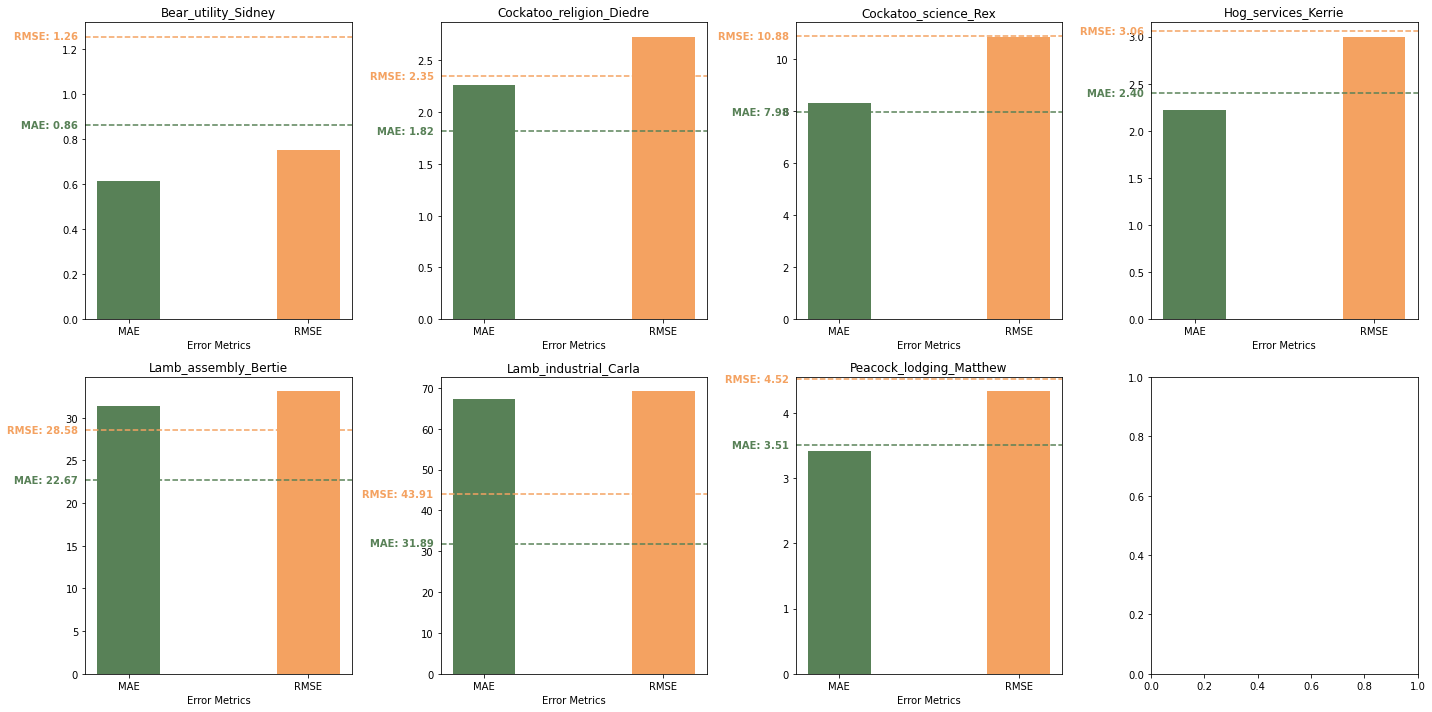

There are 4 buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough ['Cockatoo_religion_Diedre', 'Cockatoo_science_Rex', 'Lamb_assembly_Bertie', 'Lamb_industrial_Carla']


In [65]:
# Create subplots with a single row and multiple columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

revisit_daily_again = []

for i, name in enumerate(revisit_daily): 
    
    # Load the benchmark rmse and mae of the 
    bench_rmse = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'daily')]['RMSE'].values[0]
    bench_mae = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'daily')]['MAE'].values[0]
    
    # Load the previoulerror from the prediction made 
    error_entry = [err for err in errors_revisit if (err[0] == name) and (err[4] == 'daily') ]
    obtained_mae = error_entry[0][1]
    obtained_rmse = error_entry[0][3]
    
    if (obtained_mae >= bench_mae or obtained_rmse >= bench_rmse): 
        revisit_daily_again.append(name)
    
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    x  = np.arange(2)  # Two error metrics (MAE and RMSE)
    width = 0.35
    
    # Plot the bars for obtained values in green and orange
    ax.bar(x, [obtained_mae, obtained_rmse], width, color=colors)
    
    # Plot horizontal dashed lines for benchmark values with matching colors
    ax.axhline(bench_mae, color=colors[0], linestyle='--', label='bench')
    ax.axhline(bench_rmse, color=colors[1], linestyle='--')
    
    
    # Annotate the MAE and the RMSE benchmarks values on the horizontal dashed lines 
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_mae, "MAE: {:.2f}".format(bench_mae), color=colors[0], transform=trans, 
        ha="right", va="center", weight='bold' )
    
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_rmse, "RMSE: {:.2f}".format(bench_rmse), color=colors[1], transform=trans, ha="right", va="center", weight='bold' )
    
    
    ax.set_xlabel('Error Metrics')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(['MAE', 'RMSE'])
    
    
    

plt.tight_layout()
plt.show()

print("There are {} buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough {}".format(len(revisit_daily_again), revisit_daily_again))

### 8.2 Plot the weekly benchmarks and the newly obtained results 

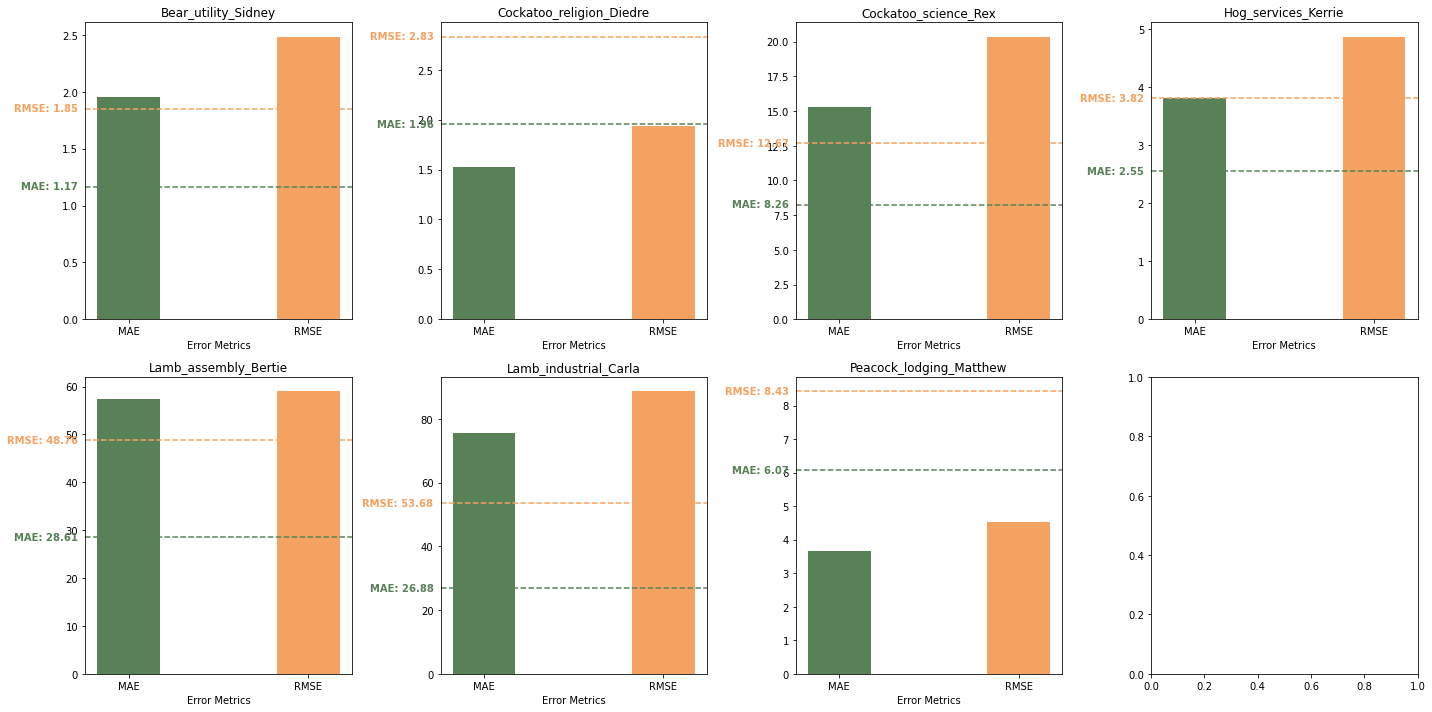

There are 5 buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough ['Bear_utility_Sidney', 'Cockatoo_science_Rex', 'Hog_services_Kerrie', 'Lamb_assembly_Bertie', 'Lamb_industrial_Carla']


In [67]:
# Create subplots with a single row and multiple columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

revisit_weekly_again = []

for i, name in enumerate(revisit_daily): 
    
    # Load the benchmark rmse and mae of the 
    bench_rmse = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'weekly')]['RMSE'].values[0]
    bench_mae = benchmarks.loc[(benchmarks['name'] == name) &  (benchmarks['horizon'] == 'weekly')]['MAE'].values[0]
    
    # Load the previoulerror from the prediction made 
    error_entry = [err for err in errors_revisit if (err[0] == name) and (err[4] == 'weekly') ]
    obtained_mae = error_entry[0][1]
    obtained_rmse = error_entry[0][3]
    
    if (obtained_mae >= bench_mae or obtained_rmse >= bench_rmse): 
        revisit_weekly_again.append(name)
    
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    x  = np.arange(2)  # Two error metrics (MAE and RMSE)
    width = 0.35
    
    # Plot the bars for obtained values in green and orange
    ax.bar(x, [obtained_mae, obtained_rmse], width, color=colors)
    
    # Plot horizontal dashed lines for benchmark values with matching colors
    ax.axhline(bench_mae, color=colors[0], linestyle='--', label='bench')
    ax.axhline(bench_rmse, color=colors[1], linestyle='--')
    
    
    # Annotate the MAE and the RMSE benchmarks values on the horizontal dashed lines 
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_mae, "MAE: {:.2f}".format(bench_mae), color=colors[0], transform=trans, 
        ha="right", va="center", weight='bold' )
    
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,bench_rmse, "RMSE: {:.2f}".format(bench_rmse), color=colors[1], transform=trans, ha="right", va="center", weight='bold' )
    
    
    ax.set_xlabel('Error Metrics')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(['MAE', 'RMSE'])
    
    
    

plt.tight_layout()
plt.show()

print("There are {} buildings that did not beat the the benchmark. For the following buildings the prediction was not accurate enough {}".format(len(revisit_weekly_again), revisit_weekly_again))

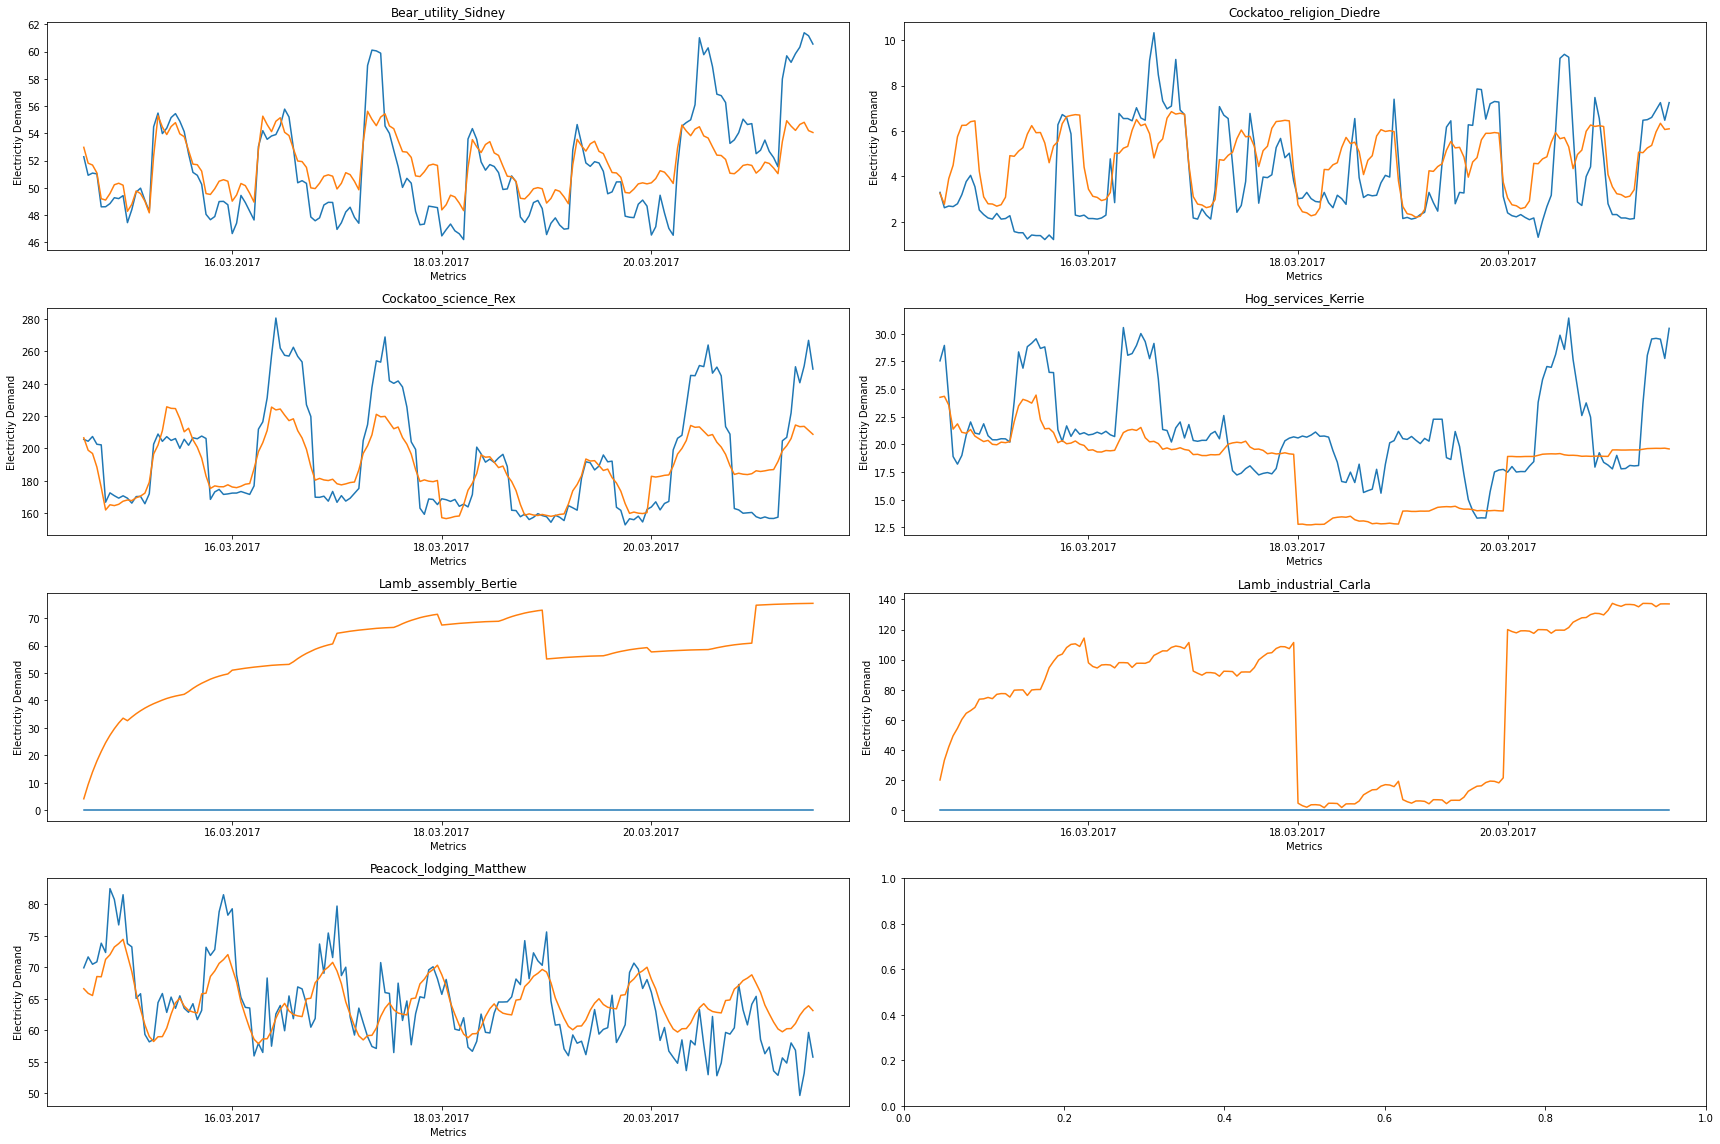

In [49]:
# Fetch the time for the predicted horizon ( one week after the training period)
x = DATES[n_train:(n_train + DATAPOINTS_ONE_WEEK)]

fig, axs = plt.subplots(4, 2, figsize=(24,16))

for i, name in enumerate(revisit_daily): 

    # Fetch the actual energy demand during the predicted week
    df_temp = df[name]
    ground_truth = df_temp[n_train: n_train + DATAPOINTS_ONE_WEEK]

    # Load the prediction
    prediction_entry = [p for p in predictions_revisit if p[0] == name]
    pred = prediction_entry[0][1]
    
    # Address the correct subplot
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    width = 0.35
    
    # Plot the ground truth during the predicted week and the actual prediction
    ax.plot(x, ground_truth, label= 'ground_truth')
    ax.plot(x, pred, label= 'prediction')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Electrictiy Demand')
    ax.set_title(name)
    
    ax.xaxis.set_major_locator(DayLocator(interval=2))
    ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()



# Final Comments

The second iteration of predictions has been done on a different week and a slightly different model. 
As the first auto_arima model had a seasonal_order of (1,0,1,24) the parameters of the second auto_arima model were (2,0,2,24) for the one-hot encoded model. As the models of the first seasonal_order were faster to compute and needed less memory space, I initially 

In [ ]:
T